
LightGBM Performance:
  R^2 Score:           0.9894
  Mean Squared Error:  48.2539
  Mean Absolute Error: 5.0370
  PHM08 Score (sum):   3236.1059
  PHM08 Score (avg):   0.7841

CatBoost Performance:
  R^2 Score:           0.9872
  Mean Squared Error:  58.3519
  Mean Absolute Error: 5.8927
  PHM08 Score (sum):   3761.2999
  PHM08 Score (avg):   0.9114

Ensemble Performance:
  R^2 Score:           0.9904
  Mean Squared Error:  43.7924
  Mean Absolute Error: 4.9591
  PHM08 Score (sum):   2951.1502
  PHM08 Score (avg):   0.7151
Plotting SHAP summary (LightGBM)...


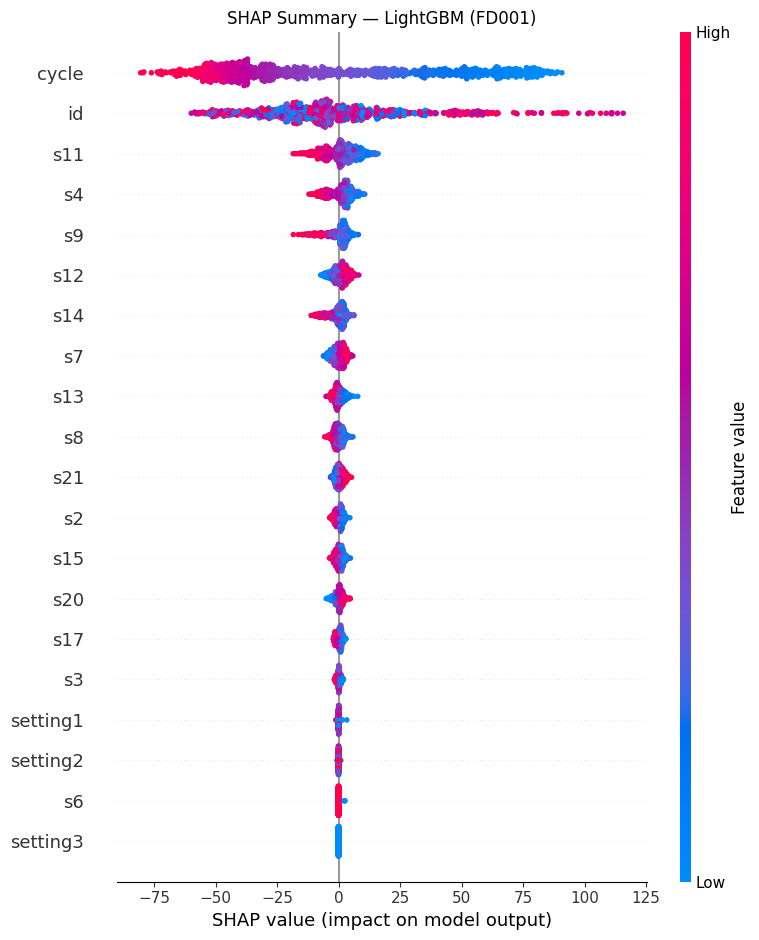

Plotting SHAP summary (CatBoost)...


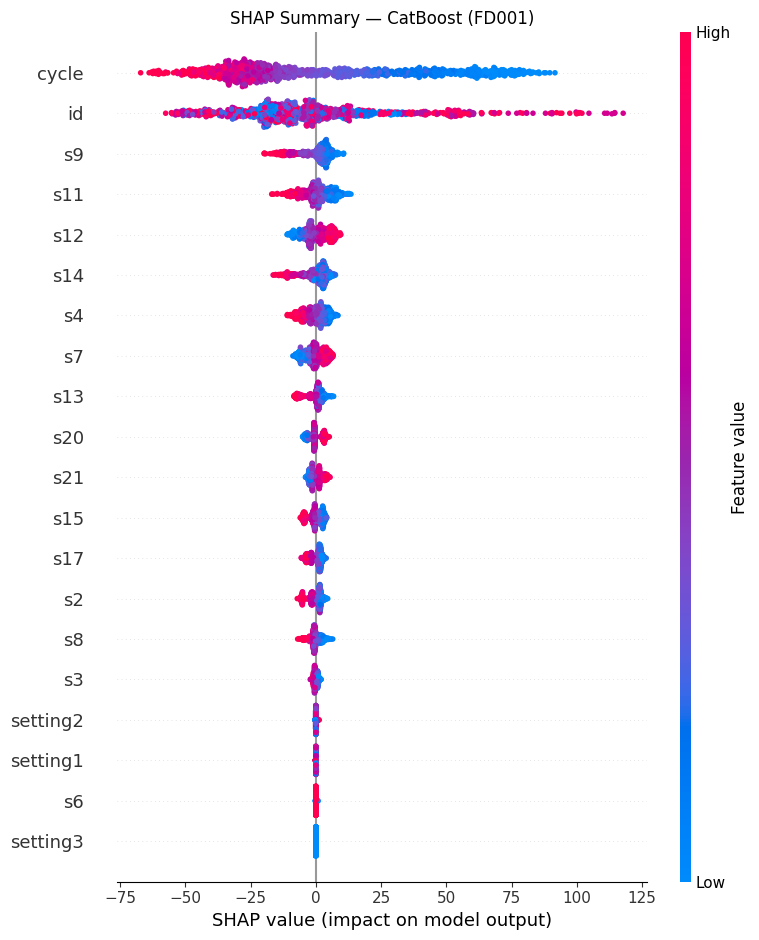

Plotting SHAP summary (Ensemble)...


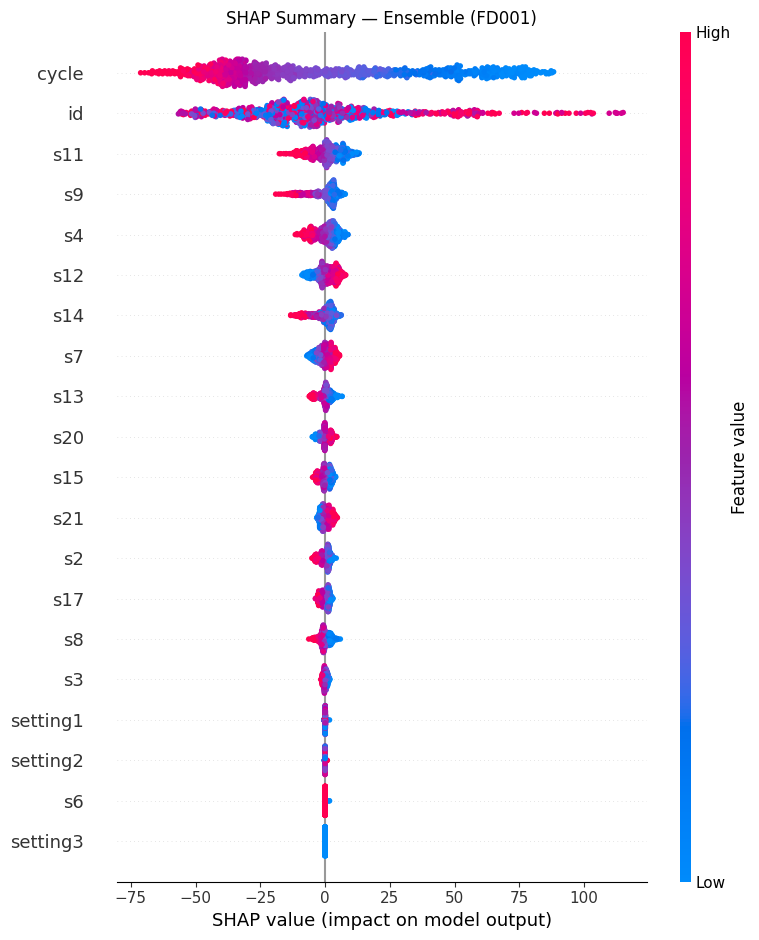

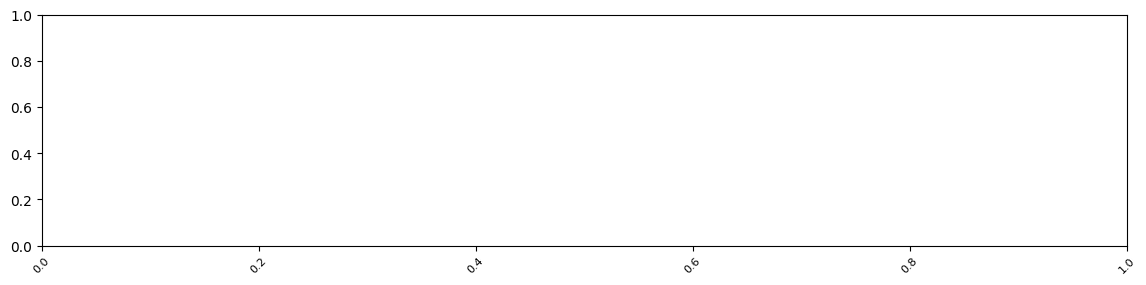

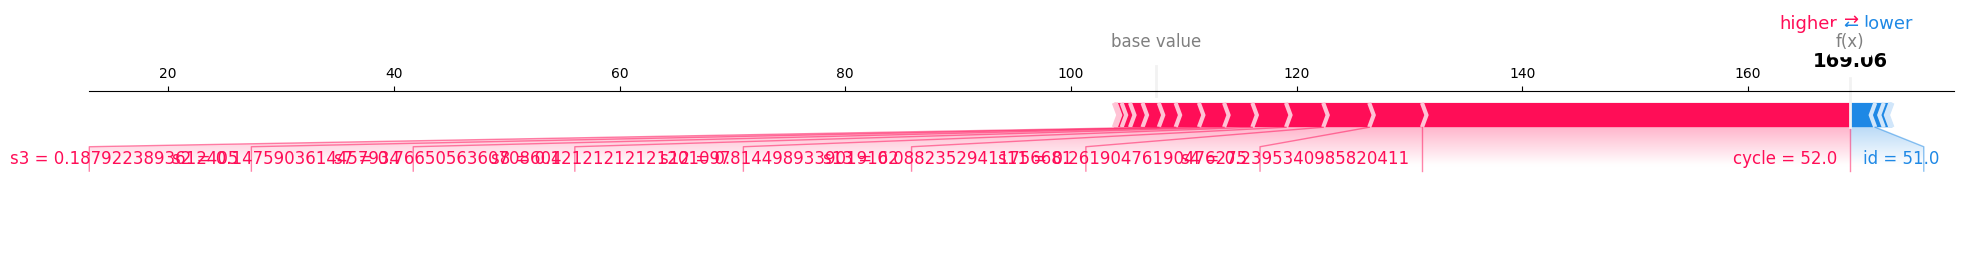

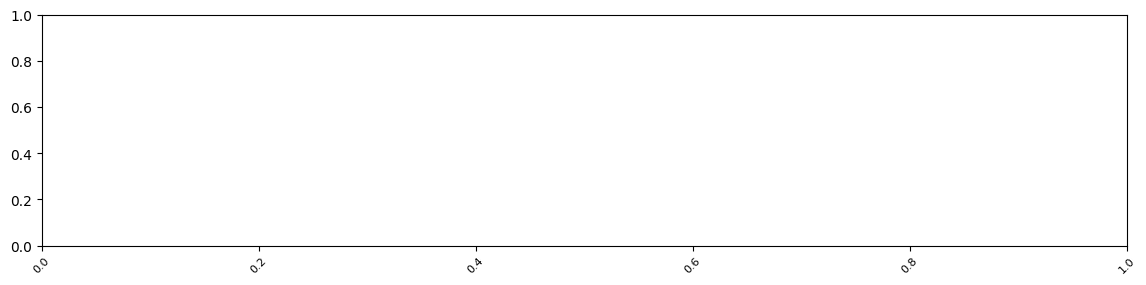

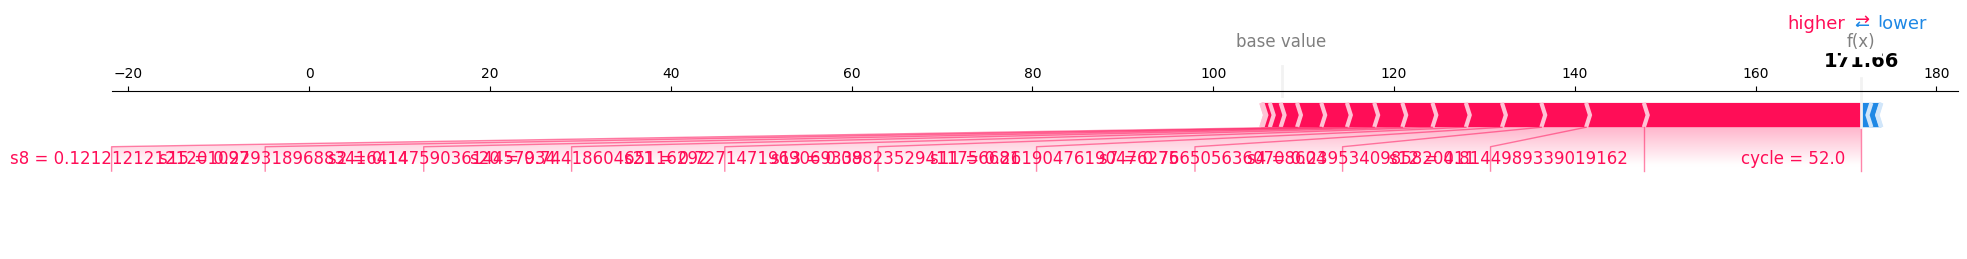

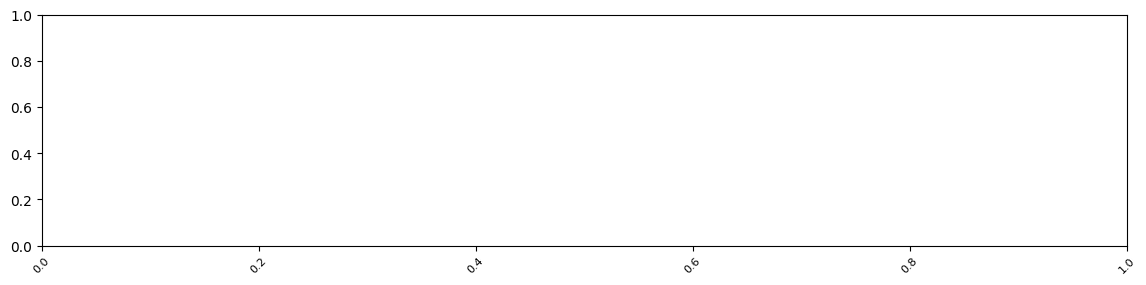

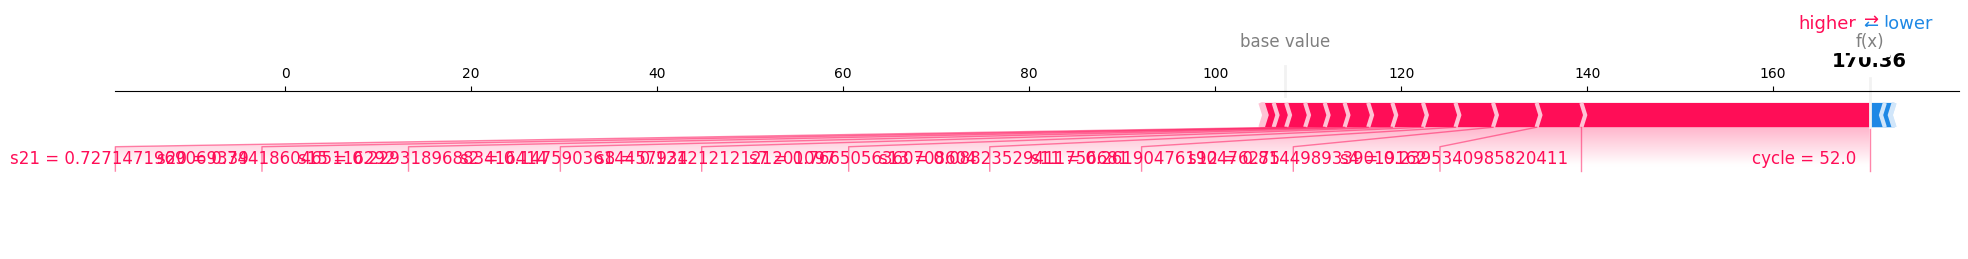

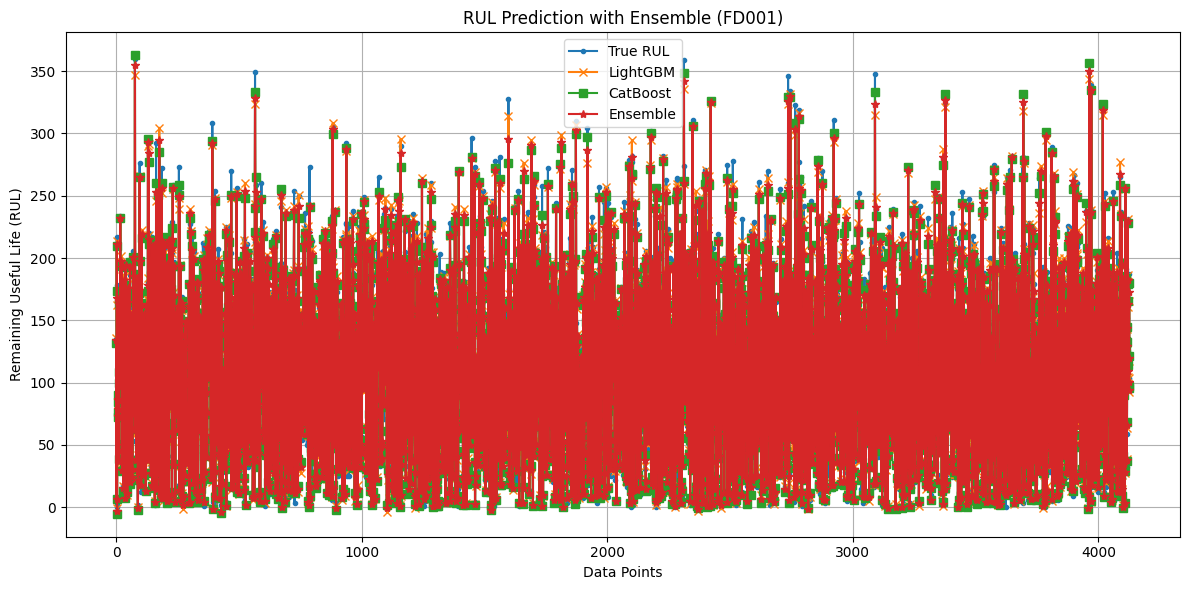



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (LightGBM) ---
Fold1: R2=0.4445, RMSE=52.7639, MAE=35.2286, PHM08_sum=3453228145.4012, PHM08_avg=838162.1712
Fold2: R2=0.4582, RMSE=50.9866, MAE=32.9904, PHM08_sum=265895358.9690, PHM08_avg=64334.7106
Fold3: R2=0.5268, RMSE=47.4301, MAE=32.6195, PHM08_sum=94078179.3477, PHM08_avg=22801.3038
Fold4: R2=0.5187, RMSE=47.1428, MAE=33.7120, PHM08_sum=135833071.9949, PHM08_avg=32929.2296
Fold5: R2=0.2299, RMSE=59.1240, MAE=41.4785, PHM08_sum=183286185772.7897, PHM08_avg=44411481.8931
Overall: R2=0.4372, RMSE=51.6747, MAE=35.2054, PHM08_sum=187235220528.5024, PHM08_avg=9075431.1729

--- GroupKFold (CatBoost) ---
Fold1: R2=0.4325, RMSE=53.3290, MAE=35.9274, PHM08_sum=5147554706.8253, PHM08_avg=1249406.4822
Fold2: R2=0.4608, RMSE=50.8662, MAE=32.8697, PHM08_sum=1

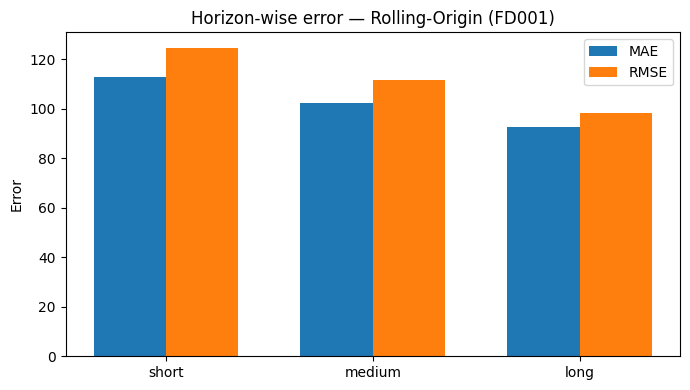

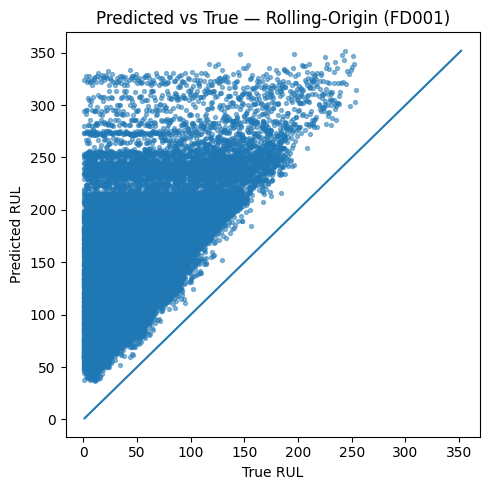


[PER-ENGINE MAE] (Top 10 worst engines)
69    151.309177
96    139.624196
92    139.194342
67    134.614795
56    129.420913
83    126.533059
86    124.720091
95    123.713190
64    122.957062
94    122.092646
dtype: float64


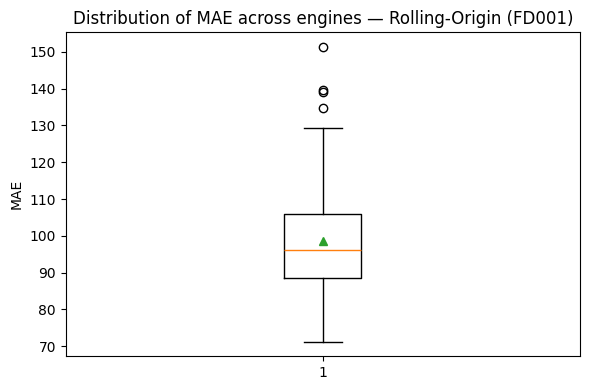

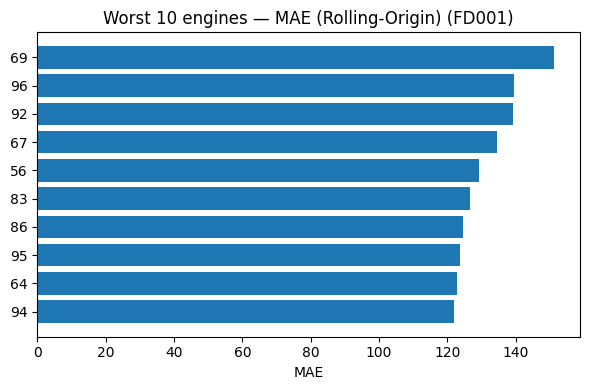


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -6.4330
    RMSE: 112.7490
     MAE: 103.0999
 sMAPE_%: 108.2293

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.4356 ± 0.1078
Without id/cycle : R²=0.5964 ± 0.0463


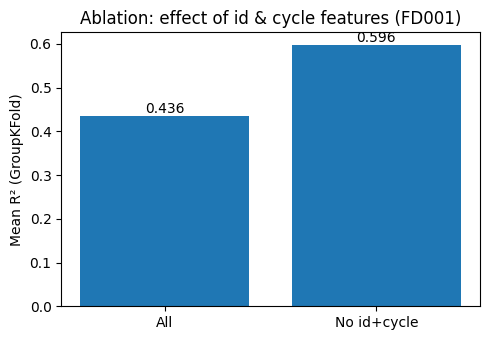


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 20631
Train (80%)   : 16504  → ratio=0.8000
Test  (20%)   : 4127  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 255.99 seconds
CPU% at start        : 18.1%   (~0.47 GHz)
CPU% at end          : 87.0%   (~2.26 GHz)
Memory at start      : 325.52 MB
Memory at end        : 522.38 MB   (Δ 196.86 MB)


In [1]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD001"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "catboostlightgbm"

# Fixed model hyperparameters (as requested)
LGB_PARAMS = dict(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=-1,      # silence LightGBM warnings
)

CB_PARAMS = dict(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,         # silence CatBoost training logs
    loss_function='RMSE'
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

# ============================================
# Output paths — single, unified directory
# ============================================
# All outputs (PNG, TXT, CSV) go into this folder:
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    """Save current matplotlib figure as PNG into OUTPUT_DIR."""
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    """Save text into OUTPUT_DIR."""
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    """Save DataFrame as CSV into OUTPUT_DIR."""
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# Model training (LightGBM + CatBoost)
# ============================================
lgb_model = lgb.LGBMRegressor(**LGB_PARAMS)
lgb_model.fit(X_train, y_train)
y_lgb = lgb_model.predict(X_val)

cb_model = CatBoostRegressor(**CB_PARAMS)
cb_model.fit(X_train, y_train)
y_cb = cb_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_lgb + 0.5 * y_cb

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_lgb = print_block_metrics("LightGBM", y_val, y_lgb)
m_cb  = print_block_metrics("CatBoost", y_val, y_cb)
m_ens = print_block_metrics("Ensemble", y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_lgb, m_cb, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer) + Ensemble SHAP
# ============================================
n_samples = min(1000, X_val.shape[0])
X_shap = X_val.sample(n=n_samples, random_state=42)

# LightGBM
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_vals_lgb = explainer_lgb.shap_values(X_shap)
print("Plotting SHAP summary (LightGBM)...")
shap.summary_plot(shap_vals_lgb, X_shap, show=False)
plt.title(f"SHAP Summary — LightGBM ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_LightGBM_{DATASET_NAME}.png")
plt.show()

# CatBoost
pool = Pool(X_shap)
cat_shap = cb_model.get_feature_importance(data=pool, type='ShapValues')
cat_shap = np.array(cat_shap)
# CatBoost returns [n_samples, n_features+1] with last column the expected value; for multiclass it's 3D
shap_vals_cat = cat_shap[:, :-1] if cat_shap.ndim == 2 else cat_shap[:, :, :-1].mean(axis=0)
print("Plotting SHAP summary (CatBoost)...")
shap.summary_plot(shap_vals_cat, X_shap, show=False)
plt.title(f"SHAP Summary — CatBoost ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_CatBoost_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP: simple average of per-feature contributions
shap_vals_ens = (shap_vals_lgb + shap_vals_cat) / 2
print("Plotting SHAP summary (Ensemble)...")
shap.summary_plot(shap_vals_ens, X_shap, show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# Single-row force plots
row = X_shap.iloc[[0]]
sv_lgb_row = explainer_lgb.shap_values(row)
if isinstance(sv_lgb_row, list):  # compatibility for multiclass API
    sv_lgb_row = sv_lgb_row[0]
sv_lgb_row = np.asarray(sv_lgb_row)[0]
expected_lgb = explainer_lgb.expected_value
if isinstance(expected_lgb, (list, np.ndarray)):
    expected_lgb = float(np.asarray(expected_lgb).mean())

pool_row = Pool(row)
cat_row_full = cb_model.get_feature_importance(data=pool_row, type="ShapValues")  # (1, n_features+1)
sv_cat_row = cat_row_full[0, :-1]
expected_cb = float(cat_row_full[0, -1])

sv_ens_row = (sv_lgb_row + sv_cat_row) / 2.0
expected_ens = (expected_lgb + expected_cb) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_lgb, sv_lgb_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_LightGBM_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_cb, sv_cat_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_CatBoost_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_ens, sv_ens_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_lgb)),      y_lgb,          label="LightGBM",  marker='x')
plt.plot(range(len(y_cb)),       y_cb,           label="CatBoost",  marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30          # window length (cycles) for purge guidance
H = 1           # prediction horizon (steps ahead)
EMBARGO = 10    # cycles to skip between train/test within a split
N_SPLITS = 5    # number of rolling-origin cuts per engine

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaler
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_lgb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", lgb.LGBMRegressor(**LGB_PARAMS))
])

pipe_cb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", CatBoostRegressor(**CB_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
overall_A_lgb = cv_eval_pipeline(X, y, groups, pipe_lgb, name="LightGBM")
overall_A_cb  = cv_eval_pipeline(X, y, groups, pipe_cb,  name="CatBoost")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))  # purge ≈ W-1
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_lgb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])

def build_pipe_cb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", CatBoostRegressor(**CB_PARAMS))
    ])

overall_B_lgb = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb, name="LightGBM"
)
overall_B_cb  = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_cb,  name="CatBoost"
)

# A/B Experiments to evidence leakage (ΔR² sensitivity)
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_lgb, name="LightGBM")
_ = cv_eval_pipeline(X, y, groups, build_pipe_lgb(), name="LightGBM (GroupKFold)")
# Rolling-origin already printed above

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb,
    embargo_val=0,  name=f"Rolling-Origin LightGBM (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb,
    embargo_val=10, name=f"Rolling-Origin LightGBM (Embargo=10, {DATASET_NAME})"
)

# Permutation (Null) Test — should collapse performance ~ baseline
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def rolling_origin_backtest_generic(df_all, features, estimator, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            est = clone(estimator)
            est.fit(X_tr, y_tr)
            p = est.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] Null test produced no folds.")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"{name}")
    return overall

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb, n_iters=1
)

# Horizon-wise error profile
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

def horizon_profile_report(y_true, y_pred, title="Horizon-wise Error"):
    dfm = pd.DataFrame({"y": y_true, "p": y_pred})
    dfm["bin"] = horizon_bins(dfm["y"])
    rows = []
    for b, g in dfm.groupby("bin"):
        rows.append(ts_metrics(g["y"].values, g["p"].values, prefix=f"{b}_"))
    print_metrics_table(rows, title=title)

hy, hp = None, None
def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb
)
if hy is not None:
    horizon_profile_report(hy, hp, title=f"Horizon-wise Error (Rolling-Origin LightGBM, {DATASET_NAME})")

print("\n================ END OF TIME-SERIES ADD-ONS ================\n")

# ===========================================
# ADDITIONAL ROBUSTNESS ANALYSES & PLOTS
# ===========================================
print("\n\n================ ADDITIONAL ROBUSTNESS ANALYSES ================\n")

# Horizon-wise error table + plots
if hy is not None:
    bins = horizon_bins(pd.Series(hy))
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": bins})
    met = (dfm
           .groupby("bin", dropna=False)
           .apply(lambda g: pd.Series({
               "MAE": mean_absolute_error(g["y"], g["p"]),
               "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
               "R2": r2_score(g["y"], g["p"])
           }))
          ).reset_index()

    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met))
    w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    lo = float(min(np.min(hy), np.min(hp)))
    hi = float(max(np.max(hy), np.max(hp)))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# Per-engine error distribution
def rolling_origin_engine_errors(df_all, features, model_builder):
    """Returns absolute errors for each engine in rolling-origin splits."""
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb
)

if per_engine:
    mae_series = pd.Series({eid: np.mean(v) for eid, v in per_engine.items()}).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))

    # Burada eski satır yerine yeni satır
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# sMAPE + overall rolling-origin metrics
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# Ablation: effect of including id & cycle
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_lgb)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_lgb)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")


LightGBM Performance:
  R^2 Score:           0.9832
  Mean Squared Error:  79.0024
  Mean Absolute Error: 6.7962
  PHM08 Score (sum):   13277.0178
  PHM08 Score (avg):   1.2348

CatBoost Performance:
  R^2 Score:           0.9498
  Mean Squared Error:  235.6130
  Mean Absolute Error: 12.0735
  PHM08 Score (sum):   39339.4042
  PHM08 Score (avg):   3.6588

Ensemble Performance:
  R^2 Score:           0.9731
  Mean Squared Error:  126.2627
  Mean Absolute Error: 8.8257
  PHM08 Score (sum):   19669.8211
  PHM08 Score (avg):   1.8294
Plotting SHAP summary (LightGBM)...


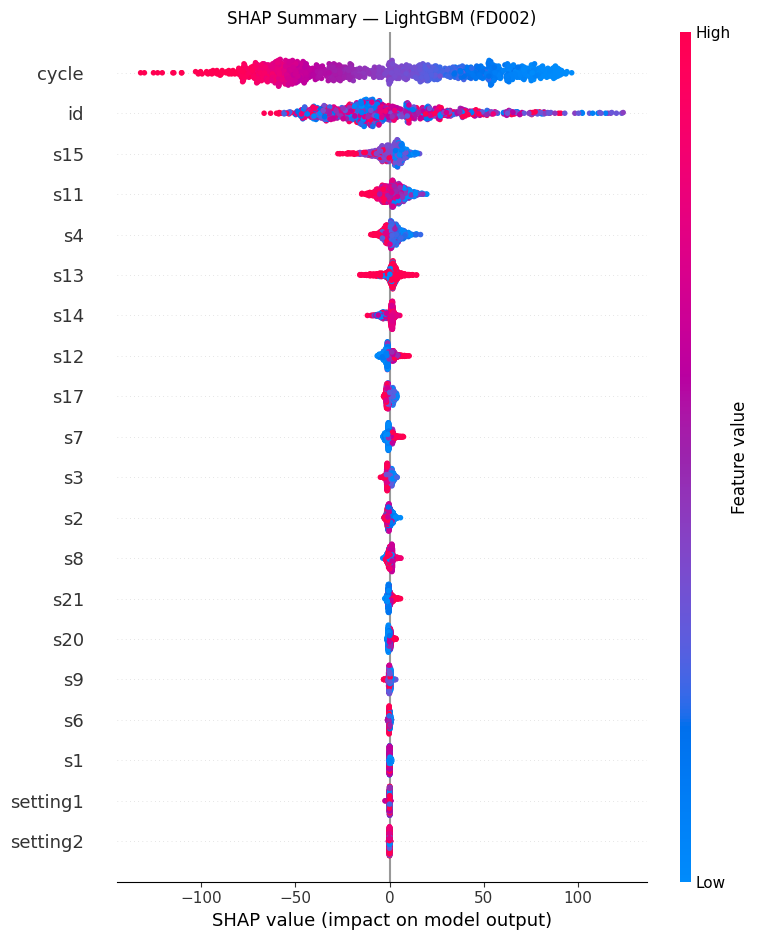

Plotting SHAP summary (CatBoost)...


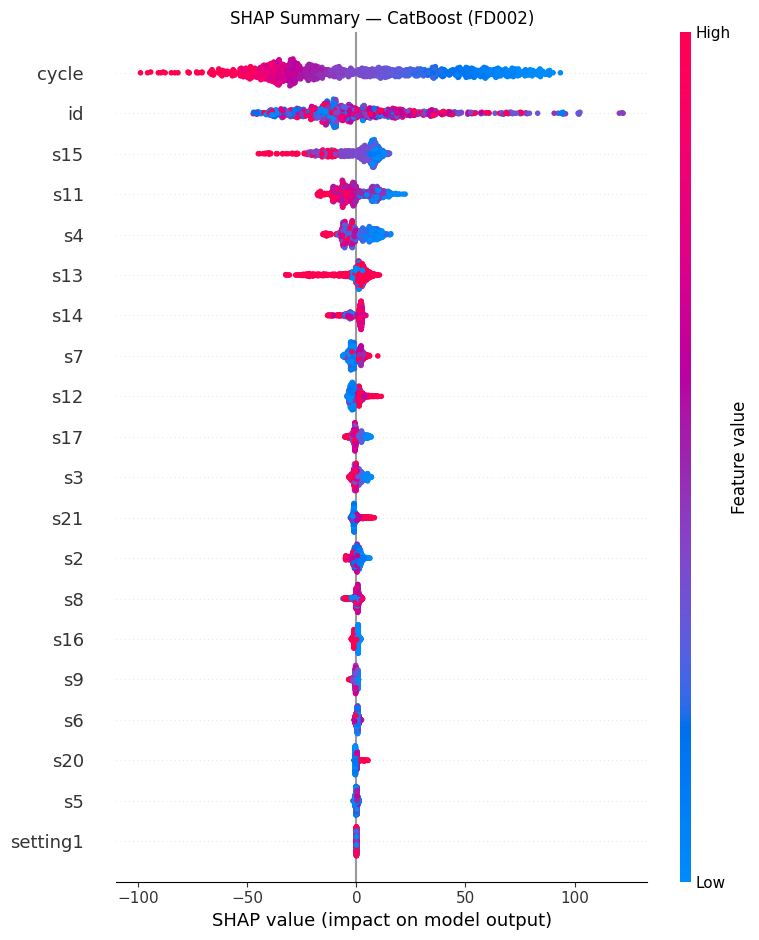

Plotting SHAP summary (Ensemble)...


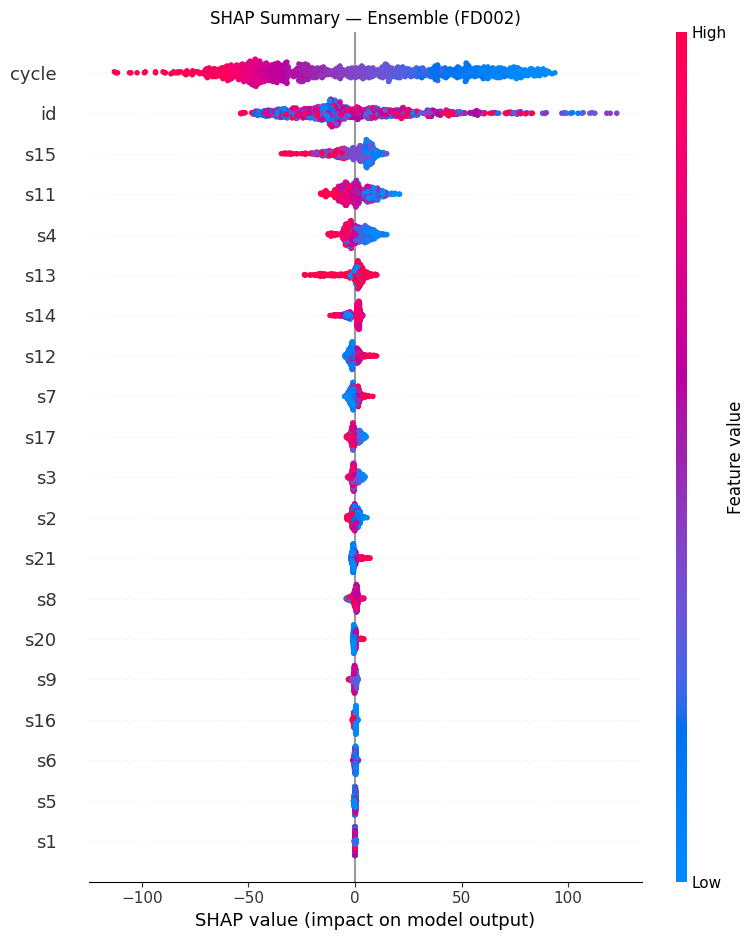

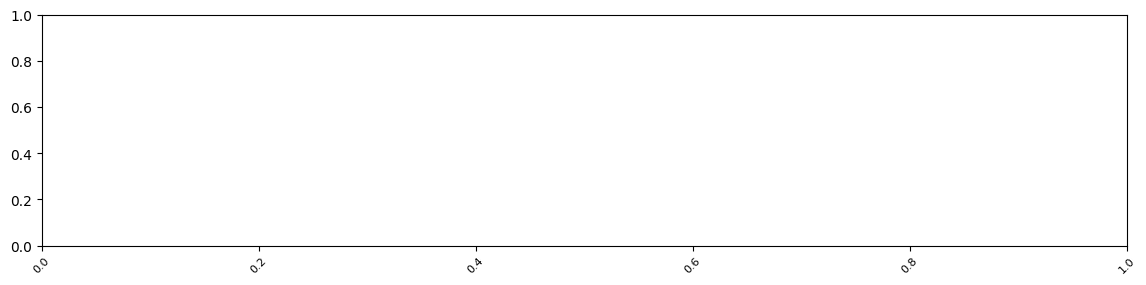

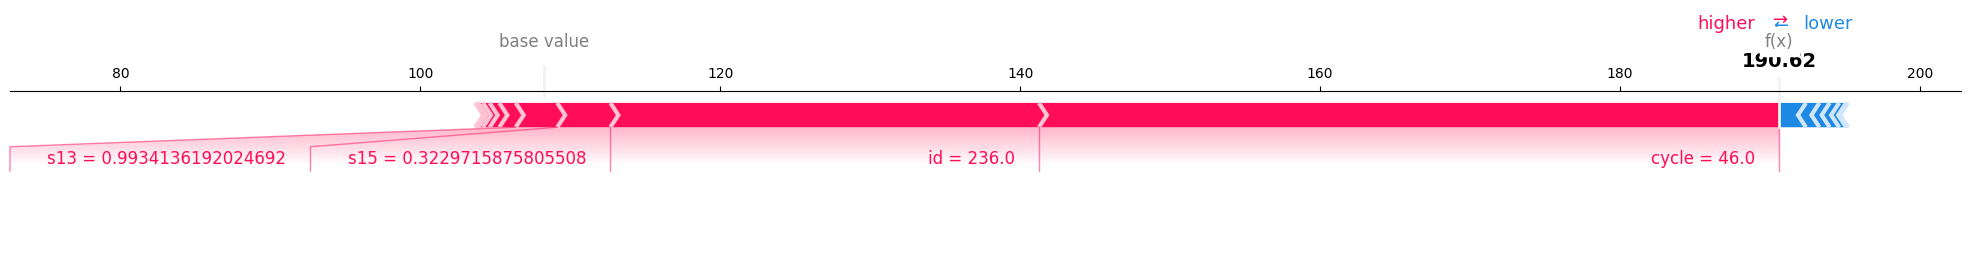

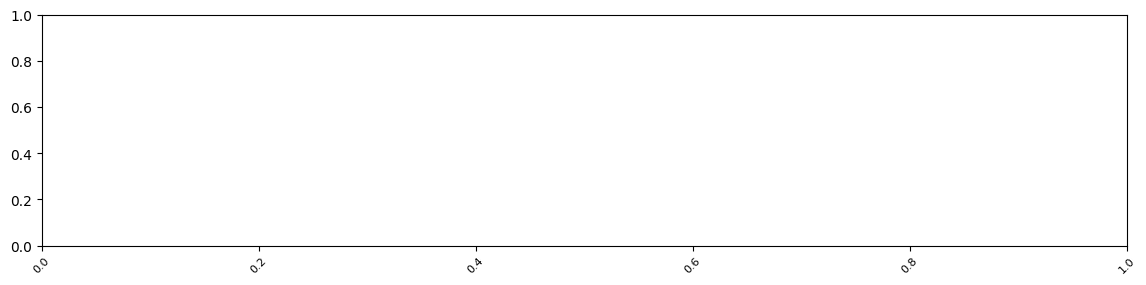

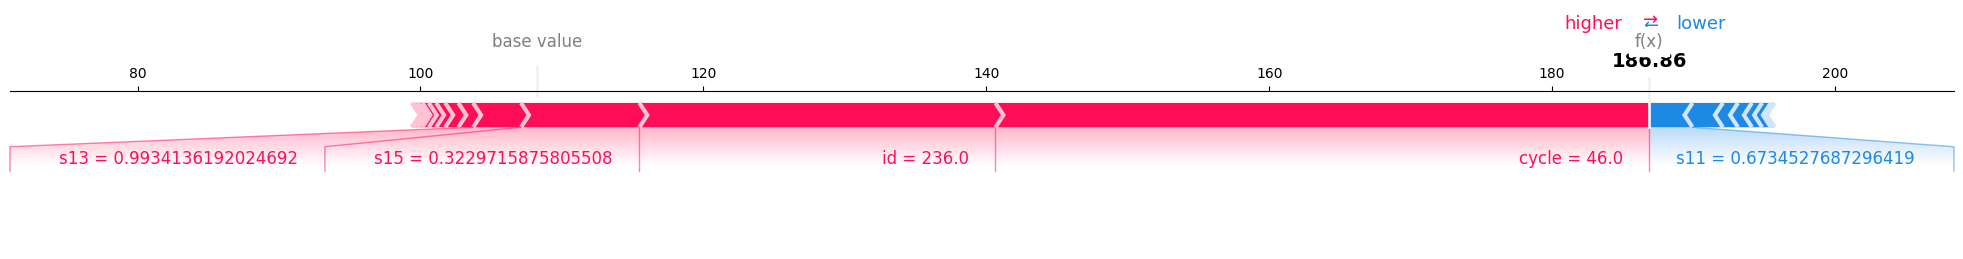

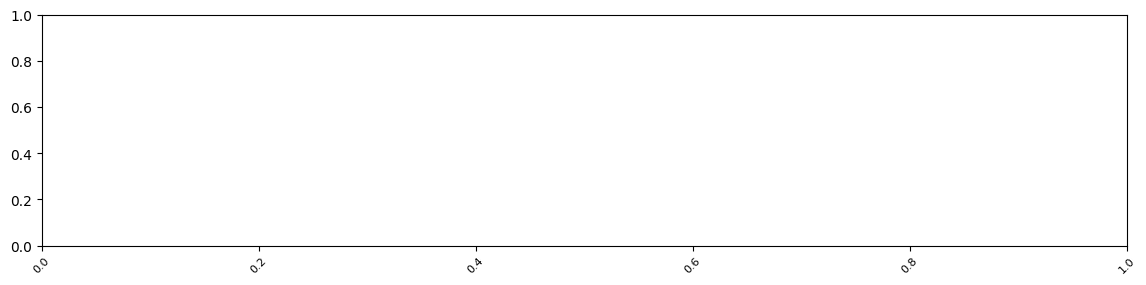

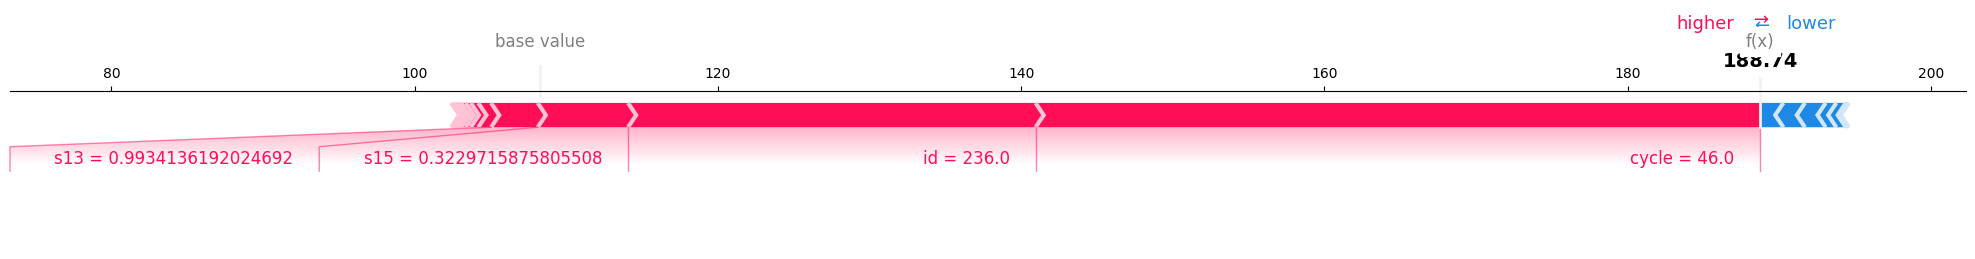

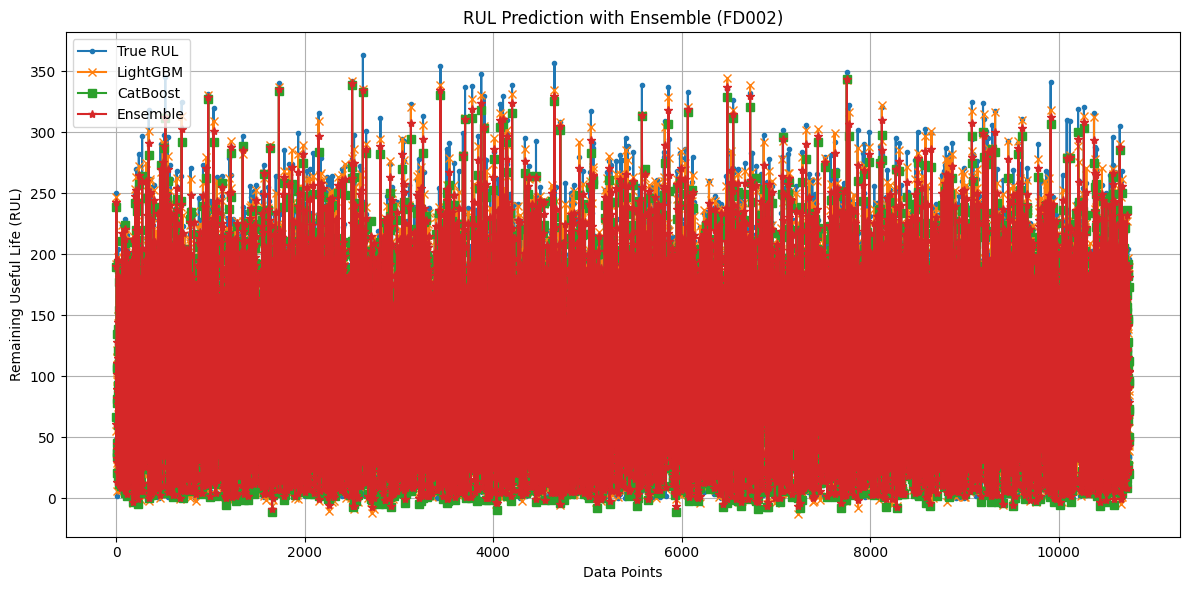



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (LightGBM) ---
Fold1: R2=0.4616, RMSE=51.0635, MAE=39.6998, PHM08_sum=78183907.0288, PHM08_avg=7269.5404
Fold2: R2=0.3948, RMSE=53.9096, MAE=40.3211, PHM08_sum=3572281057.7416, PHM08_avg=332336.1297
Fold3: R2=0.5774, RMSE=44.7952, MAE=33.0639, PHM08_sum=18902648.5002, PHM08_avg=1757.8953
Fold4: R2=0.4382, RMSE=51.6530, MAE=40.0641, PHM08_sum=75359269.4588, PHM08_avg=7008.2088
Fold5: R2=0.5303, RMSE=47.4144, MAE=36.0761, PHM08_sum=101692626.0880, PHM08_avg=9460.6592
Overall: R2=0.4803, RMSE=49.8727, MAE=37.8450, PHM08_sum=3846419508.8174, PHM08_avg=71549.3128

--- GroupKFold (CatBoost) ---
Fold1: R2=0.5343, RMSE=47.4940, MAE=36.6605, PHM08_sum=28097212.9096, PHM08_avg=2612.4791
Fold2: R2=0.4869, RMSE=49.6402, MAE=36.1633, PHM08_sum=1258097740.5620, PHM08

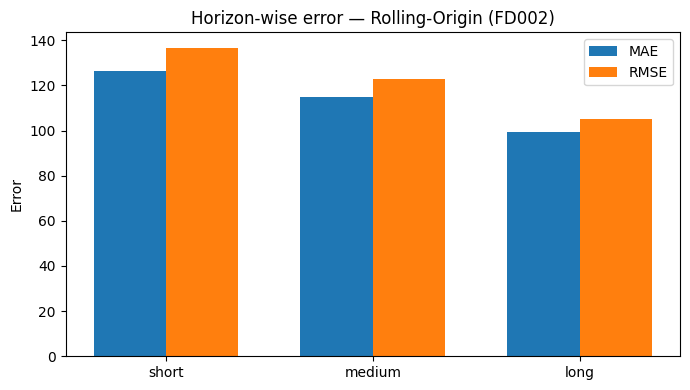

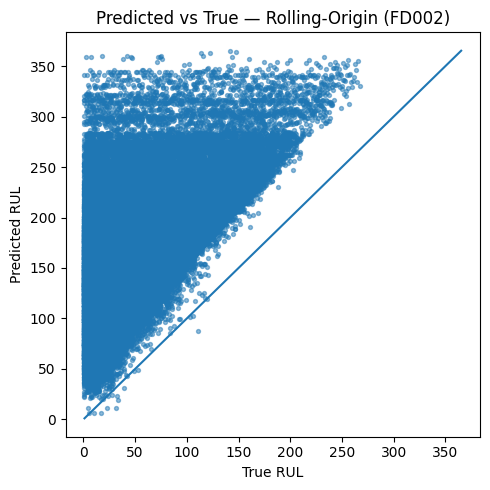


[PER-ENGINE MAE] (Top 10 worst engines)
112    169.762175
85     161.144425
88     160.653311
255    158.905291
118    154.396301
31     152.162735
260    143.434742
94     142.892523
153    142.198098
158    141.185327
dtype: float64


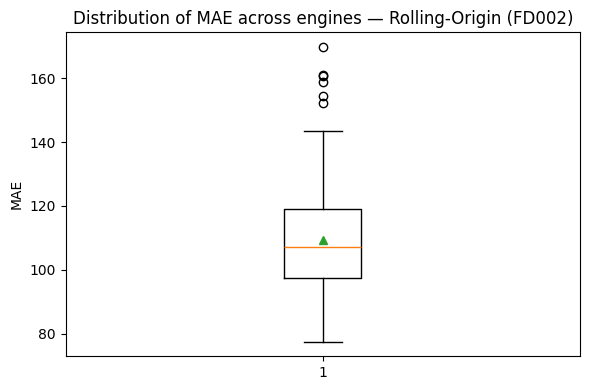

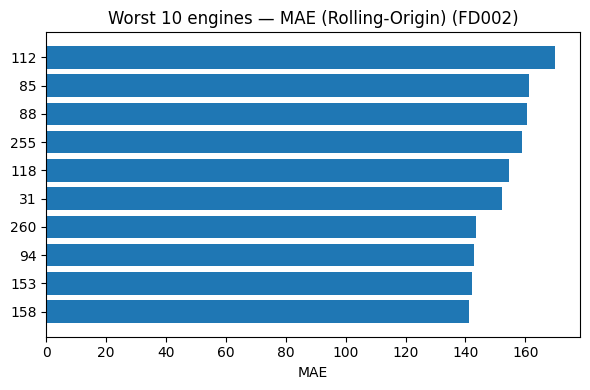


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -7.7731
    RMSE: 123.1316
     MAE: 114.3340
 sMAPE_%: 112.8338

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.4805 ± 0.0654
Without id/cycle : R²=0.5904 ± 0.0327


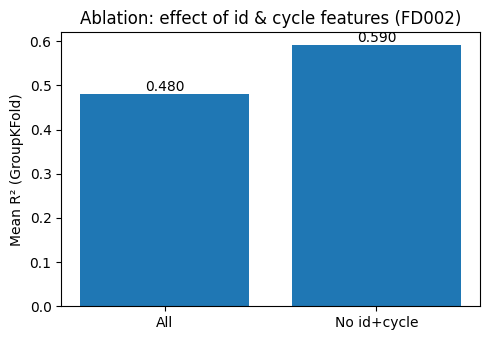


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 53759
Train (80%)   : 43007  → ratio=0.8000
Test  (20%)   : 10752  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 619.82 seconds
CPU% at start        : 4.9%   (~0.13 GHz)
CPU% at end          : 86.8%   (~2.25 GHz)
Memory at start      : 522.38 MB
Memory at end        : 804.18 MB   (Δ 281.80 MB)


In [2]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD002"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "catboostlightgbm"

# Fixed model hyperparameters (as requested)
LGB_PARAMS = dict(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=-1,      # silence LightGBM warnings
)

CB_PARAMS = dict(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,         # silence CatBoost training logs
    loss_function='RMSE'
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

# ============================================
# Output paths — single, unified directory
# ============================================
# All outputs (PNG, TXT, CSV) go into this folder:
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    """Save current matplotlib figure as PNG into OUTPUT_DIR."""
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    """Save text into OUTPUT_DIR."""
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    """Save DataFrame as CSV into OUTPUT_DIR."""
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# Model training (LightGBM + CatBoost)
# ============================================
lgb_model = lgb.LGBMRegressor(**LGB_PARAMS)
lgb_model.fit(X_train, y_train)
y_lgb = lgb_model.predict(X_val)

cb_model = CatBoostRegressor(**CB_PARAMS)
cb_model.fit(X_train, y_train)
y_cb = cb_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_lgb + 0.5 * y_cb

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_lgb = print_block_metrics("LightGBM", y_val, y_lgb)
m_cb  = print_block_metrics("CatBoost", y_val, y_cb)
m_ens = print_block_metrics("Ensemble", y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_lgb, m_cb, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer) + Ensemble SHAP
# ============================================
n_samples = min(1000, X_val.shape[0])
X_shap = X_val.sample(n=n_samples, random_state=42)

# LightGBM
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_vals_lgb = explainer_lgb.shap_values(X_shap)
print("Plotting SHAP summary (LightGBM)...")
shap.summary_plot(shap_vals_lgb, X_shap, show=False)
plt.title(f"SHAP Summary — LightGBM ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_LightGBM_{DATASET_NAME}.png")
plt.show()

# CatBoost
pool = Pool(X_shap)
cat_shap = cb_model.get_feature_importance(data=pool, type='ShapValues')
cat_shap = np.array(cat_shap)
# CatBoost returns [n_samples, n_features+1] with last column the expected value; for multiclass it's 3D
shap_vals_cat = cat_shap[:, :-1] if cat_shap.ndim == 2 else cat_shap[:, :, :-1].mean(axis=0)
print("Plotting SHAP summary (CatBoost)...")
shap.summary_plot(shap_vals_cat, X_shap, show=False)
plt.title(f"SHAP Summary — CatBoost ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_CatBoost_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP: simple average of per-feature contributions
shap_vals_ens = (shap_vals_lgb + shap_vals_cat) / 2
print("Plotting SHAP summary (Ensemble)...")
shap.summary_plot(shap_vals_ens, X_shap, show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# Single-row force plots
row = X_shap.iloc[[0]]
sv_lgb_row = explainer_lgb.shap_values(row)
if isinstance(sv_lgb_row, list):  # compatibility for multiclass API
    sv_lgb_row = sv_lgb_row[0]
sv_lgb_row = np.asarray(sv_lgb_row)[0]
expected_lgb = explainer_lgb.expected_value
if isinstance(expected_lgb, (list, np.ndarray)):
    expected_lgb = float(np.asarray(expected_lgb).mean())

pool_row = Pool(row)
cat_row_full = cb_model.get_feature_importance(data=pool_row, type="ShapValues")  # (1, n_features+1)
sv_cat_row = cat_row_full[0, :-1]
expected_cb = float(cat_row_full[0, -1])

sv_ens_row = (sv_lgb_row + sv_cat_row) / 2.0
expected_ens = (expected_lgb + expected_cb) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_lgb, sv_lgb_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_LightGBM_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_cb, sv_cat_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_CatBoost_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_ens, sv_ens_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_lgb)),      y_lgb,          label="LightGBM",  marker='x')
plt.plot(range(len(y_cb)),       y_cb,           label="CatBoost",  marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30          # window length (cycles) for purge guidance
H = 1           # prediction horizon (steps ahead)
EMBARGO = 10    # cycles to skip between train/test within a split
N_SPLITS = 5    # number of rolling-origin cuts per engine

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaler
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_lgb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", lgb.LGBMRegressor(**LGB_PARAMS))
])

pipe_cb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", CatBoostRegressor(**CB_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
overall_A_lgb = cv_eval_pipeline(X, y, groups, pipe_lgb, name="LightGBM")
overall_A_cb  = cv_eval_pipeline(X, y, groups, pipe_cb,  name="CatBoost")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))  # purge ≈ W-1
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_lgb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])

def build_pipe_cb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", CatBoostRegressor(**CB_PARAMS))
    ])

overall_B_lgb = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb, name="LightGBM"
)
overall_B_cb  = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_cb,  name="CatBoost"
)

# A/B Experiments to evidence leakage (ΔR² sensitivity)
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_lgb, name="LightGBM")
_ = cv_eval_pipeline(X, y, groups, build_pipe_lgb(), name="LightGBM (GroupKFold)")
# Rolling-origin already printed above

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb,
    embargo_val=0,  name=f"Rolling-Origin LightGBM (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb,
    embargo_val=10, name=f"Rolling-Origin LightGBM (Embargo=10, {DATASET_NAME})"
)

# Permutation (Null) Test — should collapse performance ~ baseline
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def rolling_origin_backtest_generic(df_all, features, estimator, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            est = clone(estimator)
            est.fit(X_tr, y_tr)
            p = est.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] Null test produced no folds.")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"{name}")
    return overall

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb, n_iters=1
)

# Horizon-wise error profile
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

def horizon_profile_report(y_true, y_pred, title="Horizon-wise Error"):
    dfm = pd.DataFrame({"y": y_true, "p": y_pred})
    dfm["bin"] = horizon_bins(dfm["y"])
    rows = []
    for b, g in dfm.groupby("bin"):
        rows.append(ts_metrics(g["y"].values, g["p"].values, prefix=f"{b}_"))
    print_metrics_table(rows, title=title)

hy, hp = None, None
def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb
)
if hy is not None:
    horizon_profile_report(hy, hp, title=f"Horizon-wise Error (Rolling-Origin LightGBM, {DATASET_NAME})")

print("\n================ END OF TIME-SERIES ADD-ONS ================\n")

# ===========================================
# ADDITIONAL ROBUSTNESS ANALYSES & PLOTS
# ===========================================
print("\n\n================ ADDITIONAL ROBUSTNESS ANALYSES ================\n")

# Horizon-wise error table + plots
if hy is not None:
    bins = horizon_bins(pd.Series(hy))
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": bins})
    met = (dfm
           .groupby("bin", dropna=False)
           .apply(lambda g: pd.Series({
               "MAE": mean_absolute_error(g["y"], g["p"]),
               "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
               "R2": r2_score(g["y"], g["p"])
           }))
          ).reset_index()

    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met))
    w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    lo = float(min(np.min(hy), np.min(hp)))
    hi = float(max(np.max(hy), np.max(hp)))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# Per-engine error distribution
def rolling_origin_engine_errors(df_all, features, model_builder):
    """Returns absolute errors for each engine in rolling-origin splits."""
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb
)

if per_engine:
    mae_series = pd.Series({eid: np.mean(v) for eid, v in per_engine.items()}).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))

    # Burada eski satır yerine yeni satır
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# sMAPE + overall rolling-origin metrics
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# Ablation: effect of including id & cycle
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_lgb)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_lgb)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")


LightGBM Performance:
  R^2 Score:           0.9898
  Mean Squared Error:  99.7244
  Mean Absolute Error: 6.9449
  PHM08 Score (sum):   15041.6702
  PHM08 Score (avg):   3.0424

CatBoost Performance:
  R^2 Score:           0.9854
  Mean Squared Error:  143.2805
  Mean Absolute Error: 8.6236
  PHM08 Score (sum):   21036.0152
  PHM08 Score (avg):   4.2549

Ensemble Performance:
  R^2 Score:           0.9900
  Mean Squared Error:  98.0759
  Mean Absolute Error: 6.9766
  PHM08 Score (sum):   10565.8667
  PHM08 Score (avg):   2.1371
Plotting SHAP summary (LightGBM)...


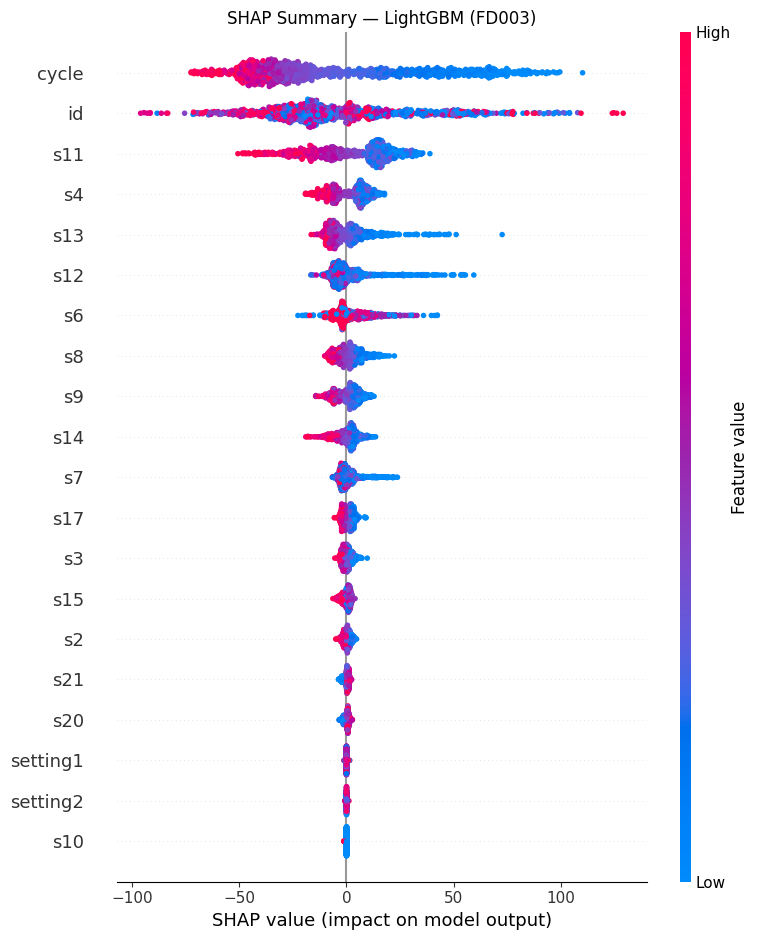

Plotting SHAP summary (CatBoost)...


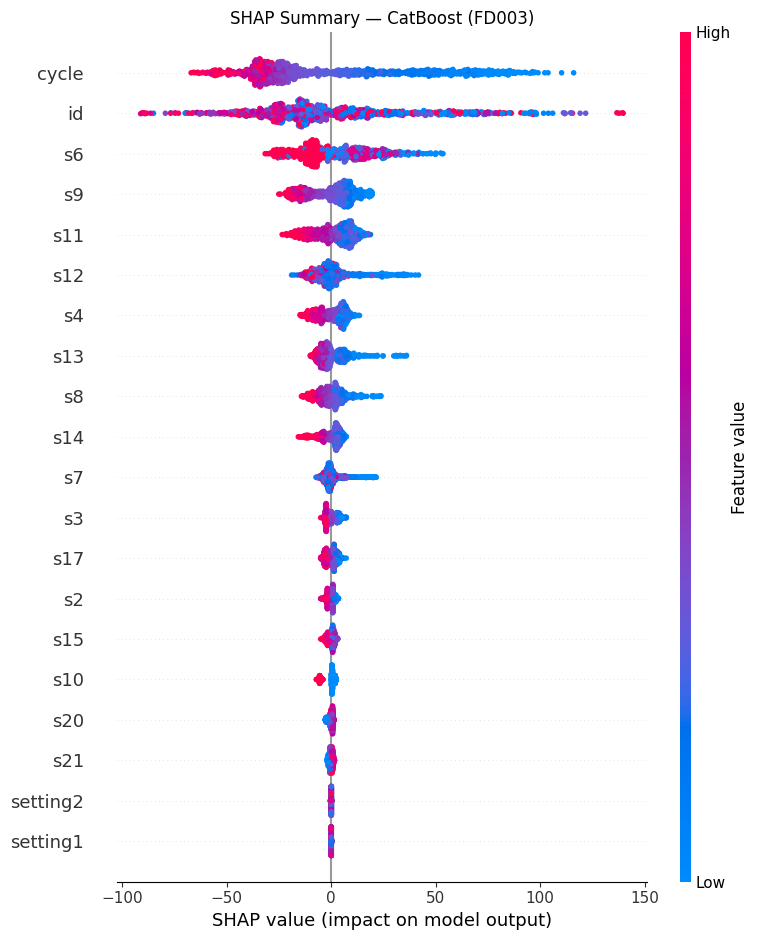

Plotting SHAP summary (Ensemble)...


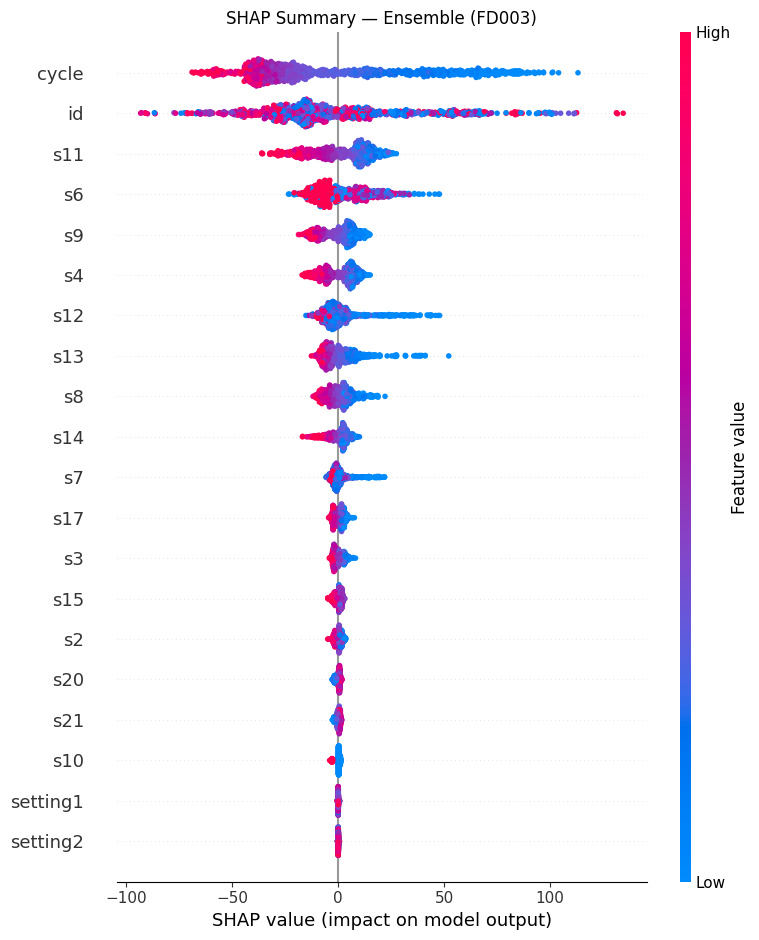

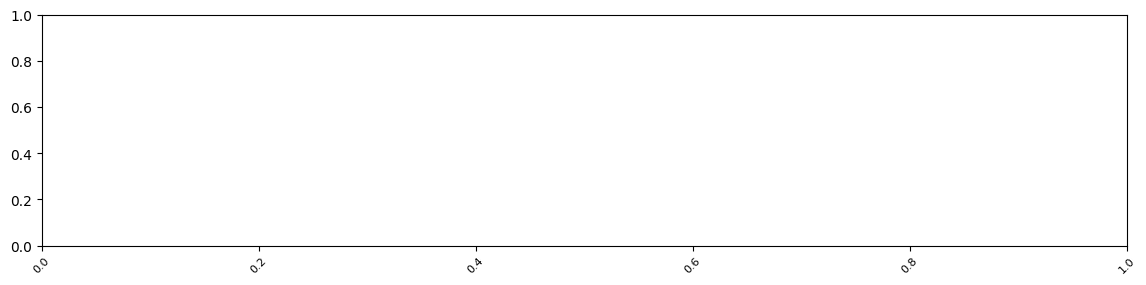

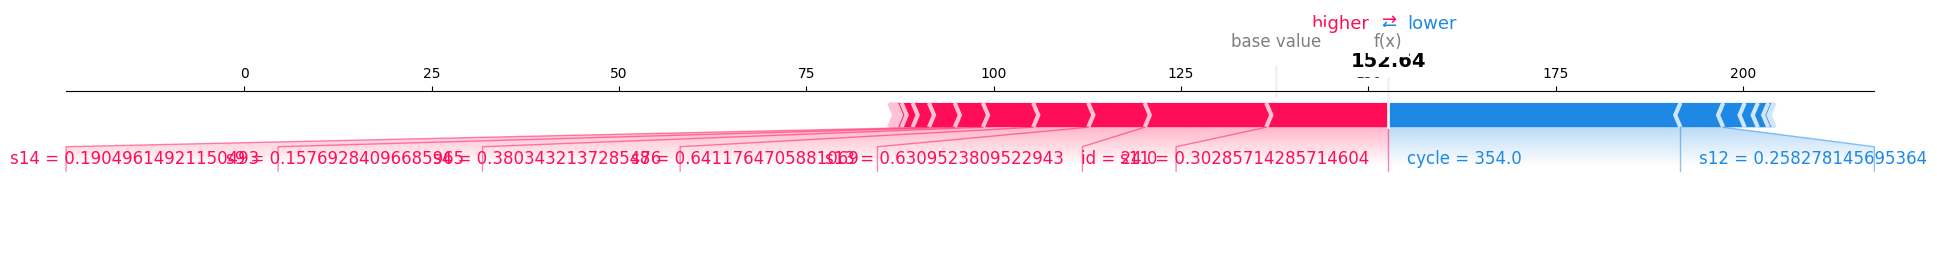

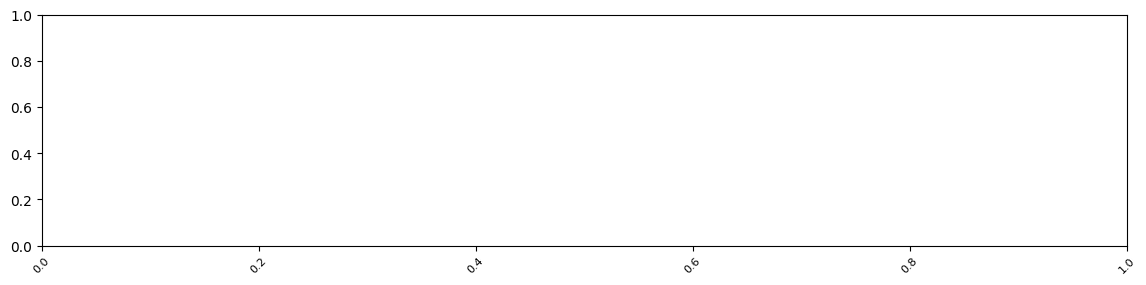

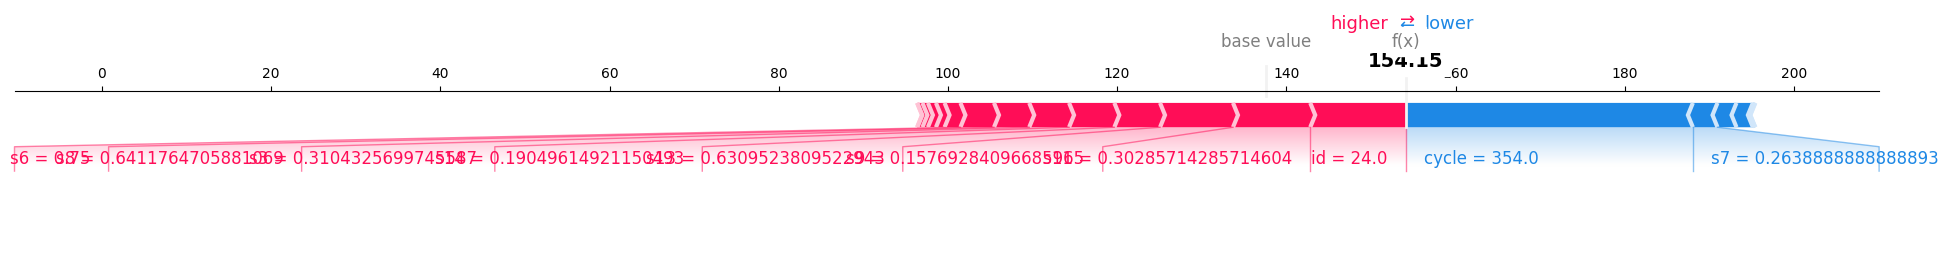

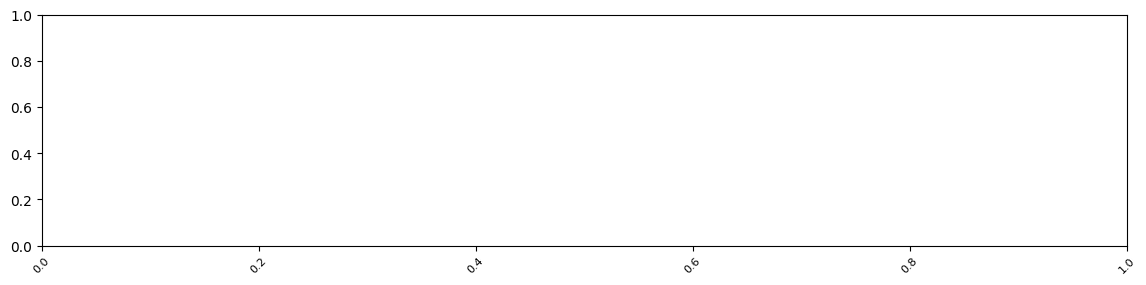

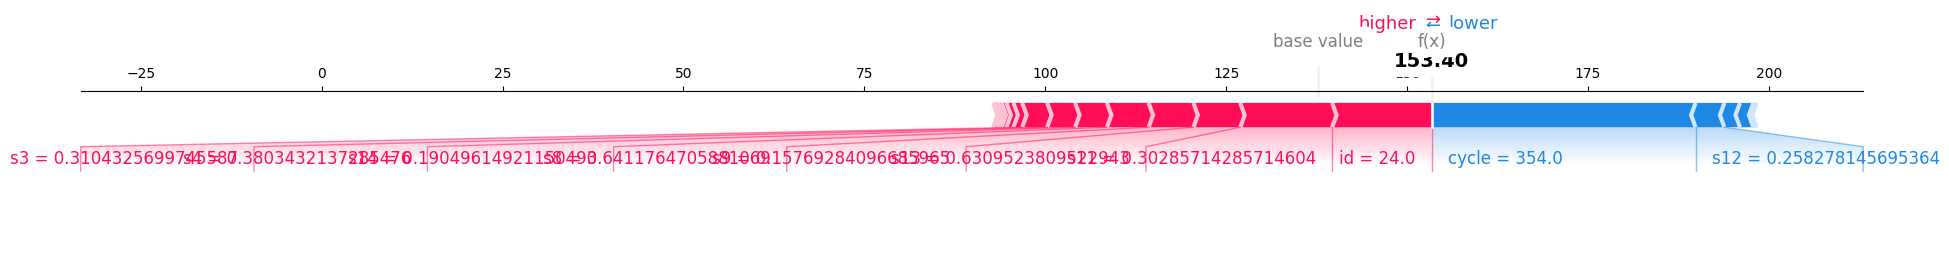

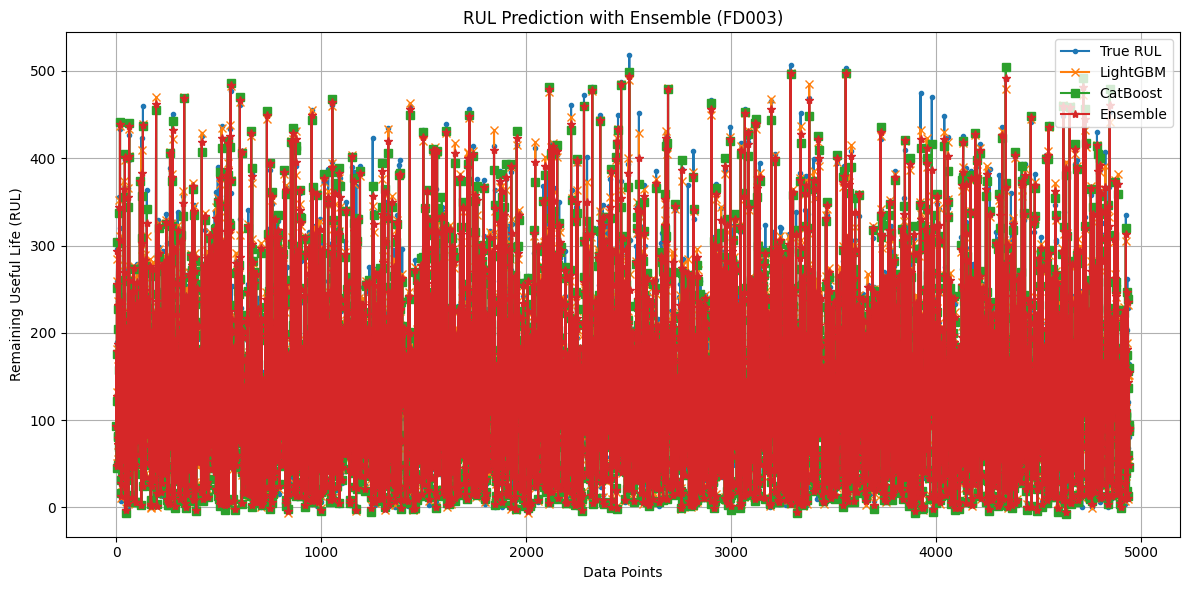



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (LightGBM) ---
Fold1: R2=0.3503, RMSE=81.6586, MAE=55.0811, PHM08_sum=159418868659.0696, PHM08_avg=32257966.1390
Fold2: R2=0.6962, RMSE=54.3734, MAE=38.1615, PHM08_sum=7339140149.6124, PHM08_avg=1483853.6493
Fold3: R2=0.2514, RMSE=85.0878, MAE=60.0028, PHM08_sum=133997573934739.0156, PHM08_avg=27092109570.3071
Fold4: R2=0.4029, RMSE=75.8380, MAE=51.4218, PHM08_sum=711053612886.2390, PHM08_avg=143937978.3171
Fold5: R2=0.3739, RMSE=77.3260, MAE=56.8339, PHM08_sum=9243277420.6857, PHM08_avg=1868838.9447
Overall: R2=0.4147, RMSE=75.6233, MAE=52.3000, PHM08_sum=134884628833854.5938, PHM08_avg=5456497930.1721

--- GroupKFold (CatBoost) ---
Fold1: R2=0.3705, RMSE=80.3815, MAE=55.4336, PHM08_sum=42731597661.7915, PHM08_avg=8646620.3282
Fold2: R2=0.5621, RMSE=65

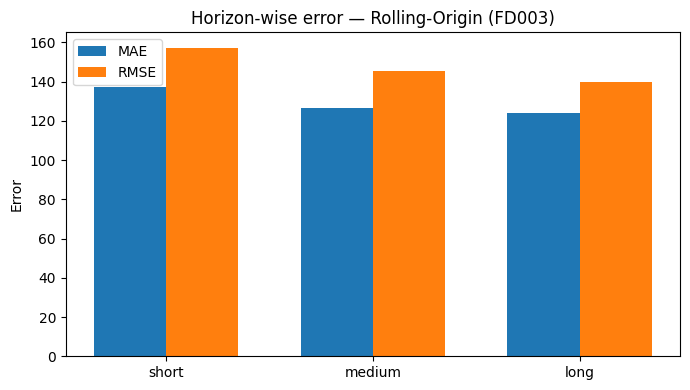

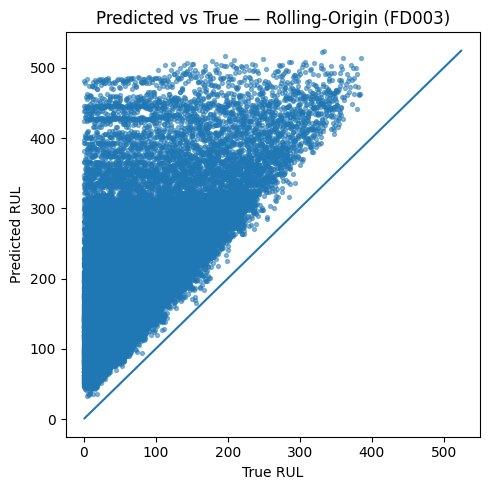


[PER-ENGINE MAE] (Top 10 worst engines)
55    214.785392
10    209.490148
96    199.765812
71    191.774565
34    188.963415
24    184.578586
18    183.880886
9     176.053538
7     169.801012
27    158.307083
dtype: float64


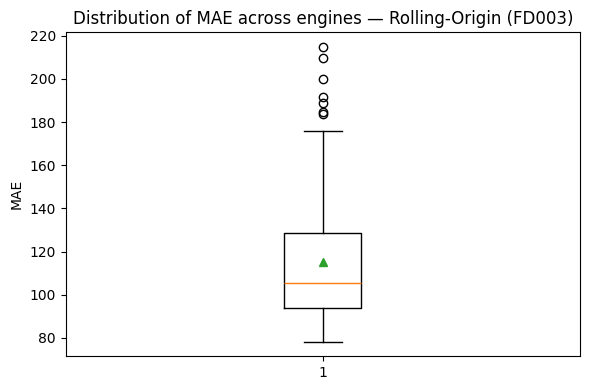

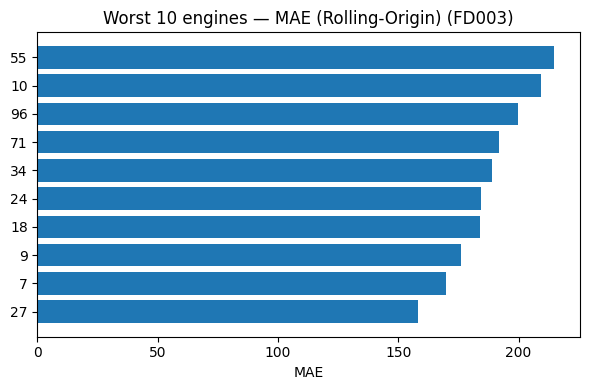


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -4.4196
    RMSE: 146.3740
     MAE: 128.4208
 sMAPE_%: 104.8566

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.4150 ± 0.1496
Without id/cycle : R²=0.5535 ± 0.0920


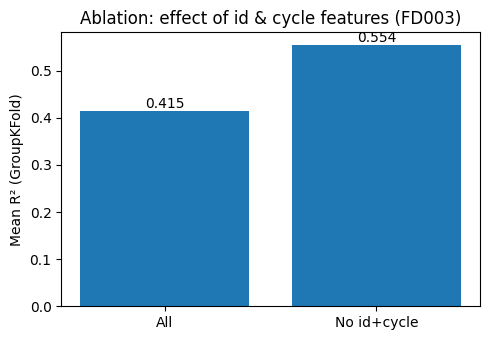


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 24720
Train (80%)   : 19776  → ratio=0.8000
Test  (20%)   : 4944  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 248.07 seconds
CPU% at start        : 18.2%   (~0.47 GHz)
CPU% at end          : 88.2%   (~2.29 GHz)
Memory at start      : 804.44 MB
Memory at end        : 727.55 MB   (Δ -76.88 MB)


In [3]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD003"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "catboostlightgbm"

# Fixed model hyperparameters (as requested)
LGB_PARAMS = dict(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=-1,      # silence LightGBM warnings
)

CB_PARAMS = dict(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,         # silence CatBoost training logs
    loss_function='RMSE'
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

# ============================================
# Output paths — single, unified directory
# ============================================
# All outputs (PNG, TXT, CSV) go into this folder:
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    """Save current matplotlib figure as PNG into OUTPUT_DIR."""
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    """Save text into OUTPUT_DIR."""
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    """Save DataFrame as CSV into OUTPUT_DIR."""
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# Model training (LightGBM + CatBoost)
# ============================================
lgb_model = lgb.LGBMRegressor(**LGB_PARAMS)
lgb_model.fit(X_train, y_train)
y_lgb = lgb_model.predict(X_val)

cb_model = CatBoostRegressor(**CB_PARAMS)
cb_model.fit(X_train, y_train)
y_cb = cb_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_lgb + 0.5 * y_cb

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_lgb = print_block_metrics("LightGBM", y_val, y_lgb)
m_cb  = print_block_metrics("CatBoost", y_val, y_cb)
m_ens = print_block_metrics("Ensemble", y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_lgb, m_cb, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer) + Ensemble SHAP
# ============================================
n_samples = min(1000, X_val.shape[0])
X_shap = X_val.sample(n=n_samples, random_state=42)

# LightGBM
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_vals_lgb = explainer_lgb.shap_values(X_shap)
print("Plotting SHAP summary (LightGBM)...")
shap.summary_plot(shap_vals_lgb, X_shap, show=False)
plt.title(f"SHAP Summary — LightGBM ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_LightGBM_{DATASET_NAME}.png")
plt.show()

# CatBoost
pool = Pool(X_shap)
cat_shap = cb_model.get_feature_importance(data=pool, type='ShapValues')
cat_shap = np.array(cat_shap)
# CatBoost returns [n_samples, n_features+1] with last column the expected value; for multiclass it's 3D
shap_vals_cat = cat_shap[:, :-1] if cat_shap.ndim == 2 else cat_shap[:, :, :-1].mean(axis=0)
print("Plotting SHAP summary (CatBoost)...")
shap.summary_plot(shap_vals_cat, X_shap, show=False)
plt.title(f"SHAP Summary — CatBoost ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_CatBoost_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP: simple average of per-feature contributions
shap_vals_ens = (shap_vals_lgb + shap_vals_cat) / 2
print("Plotting SHAP summary (Ensemble)...")
shap.summary_plot(shap_vals_ens, X_shap, show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# Single-row force plots
row = X_shap.iloc[[0]]
sv_lgb_row = explainer_lgb.shap_values(row)
if isinstance(sv_lgb_row, list):  # compatibility for multiclass API
    sv_lgb_row = sv_lgb_row[0]
sv_lgb_row = np.asarray(sv_lgb_row)[0]
expected_lgb = explainer_lgb.expected_value
if isinstance(expected_lgb, (list, np.ndarray)):
    expected_lgb = float(np.asarray(expected_lgb).mean())

pool_row = Pool(row)
cat_row_full = cb_model.get_feature_importance(data=pool_row, type="ShapValues")  # (1, n_features+1)
sv_cat_row = cat_row_full[0, :-1]
expected_cb = float(cat_row_full[0, -1])

sv_ens_row = (sv_lgb_row + sv_cat_row) / 2.0
expected_ens = (expected_lgb + expected_cb) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_lgb, sv_lgb_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_LightGBM_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_cb, sv_cat_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_CatBoost_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_ens, sv_ens_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_lgb)),      y_lgb,          label="LightGBM",  marker='x')
plt.plot(range(len(y_cb)),       y_cb,           label="CatBoost",  marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30          # window length (cycles) for purge guidance
H = 1           # prediction horizon (steps ahead)
EMBARGO = 10    # cycles to skip between train/test within a split
N_SPLITS = 5    # number of rolling-origin cuts per engine

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaler
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_lgb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", lgb.LGBMRegressor(**LGB_PARAMS))
])

pipe_cb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", CatBoostRegressor(**CB_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
overall_A_lgb = cv_eval_pipeline(X, y, groups, pipe_lgb, name="LightGBM")
overall_A_cb  = cv_eval_pipeline(X, y, groups, pipe_cb,  name="CatBoost")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))  # purge ≈ W-1
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_lgb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])

def build_pipe_cb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", CatBoostRegressor(**CB_PARAMS))
    ])

overall_B_lgb = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb, name="LightGBM"
)
overall_B_cb  = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_cb,  name="CatBoost"
)

# A/B Experiments to evidence leakage (ΔR² sensitivity)
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_lgb, name="LightGBM")
_ = cv_eval_pipeline(X, y, groups, build_pipe_lgb(), name="LightGBM (GroupKFold)")
# Rolling-origin already printed above

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb,
    embargo_val=0,  name=f"Rolling-Origin LightGBM (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb,
    embargo_val=10, name=f"Rolling-Origin LightGBM (Embargo=10, {DATASET_NAME})"
)

# Permutation (Null) Test — should collapse performance ~ baseline
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def rolling_origin_backtest_generic(df_all, features, estimator, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            est = clone(estimator)
            est.fit(X_tr, y_tr)
            p = est.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] Null test produced no folds.")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"{name}")
    return overall

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb, n_iters=1
)

# Horizon-wise error profile
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

def horizon_profile_report(y_true, y_pred, title="Horizon-wise Error"):
    dfm = pd.DataFrame({"y": y_true, "p": y_pred})
    dfm["bin"] = horizon_bins(dfm["y"])
    rows = []
    for b, g in dfm.groupby("bin"):
        rows.append(ts_metrics(g["y"].values, g["p"].values, prefix=f"{b}_"))
    print_metrics_table(rows, title=title)

hy, hp = None, None
def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb
)
if hy is not None:
    horizon_profile_report(hy, hp, title=f"Horizon-wise Error (Rolling-Origin LightGBM, {DATASET_NAME})")

print("\n================ END OF TIME-SERIES ADD-ONS ================\n")

# ===========================================
# ADDITIONAL ROBUSTNESS ANALYSES & PLOTS
# ===========================================
print("\n\n================ ADDITIONAL ROBUSTNESS ANALYSES ================\n")

# Horizon-wise error table + plots
if hy is not None:
    bins = horizon_bins(pd.Series(hy))
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": bins})
    met = (dfm
           .groupby("bin", dropna=False)
           .apply(lambda g: pd.Series({
               "MAE": mean_absolute_error(g["y"], g["p"]),
               "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
               "R2": r2_score(g["y"], g["p"])
           }))
          ).reset_index()

    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met))
    w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    lo = float(min(np.min(hy), np.min(hp)))
    hi = float(max(np.max(hy), np.max(hp)))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# Per-engine error distribution
def rolling_origin_engine_errors(df_all, features, model_builder):
    """Returns absolute errors for each engine in rolling-origin splits."""
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb
)

if per_engine:
    mae_series = pd.Series({eid: np.mean(v) for eid, v in per_engine.items()}).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))

    # Burada eski satır yerine yeni satır
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# sMAPE + overall rolling-origin metrics
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# Ablation: effect of including id & cycle
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_lgb)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_lgb)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")


LightGBM Performance:
  R^2 Score:           0.9830
  Mean Squared Error:  136.9355
  Mean Absolute Error: 8.8780
  PHM08 Score (sum):   25974.5151
  PHM08 Score (avg):   2.1204

CatBoost Performance:
  R^2 Score:           0.9403
  Mean Squared Error:  479.8289
  Mean Absolute Error: 16.9850
  PHM08 Score (sum):   174405.5979
  PHM08 Score (avg):   14.2372

Ensemble Performance:
  R^2 Score:           0.9696
  Mean Squared Error:  244.1383
  Mean Absolute Error: 12.0480
  PHM08 Score (sum):   51682.9743
  PHM08 Score (avg):   4.2190
Plotting SHAP summary (LightGBM)...


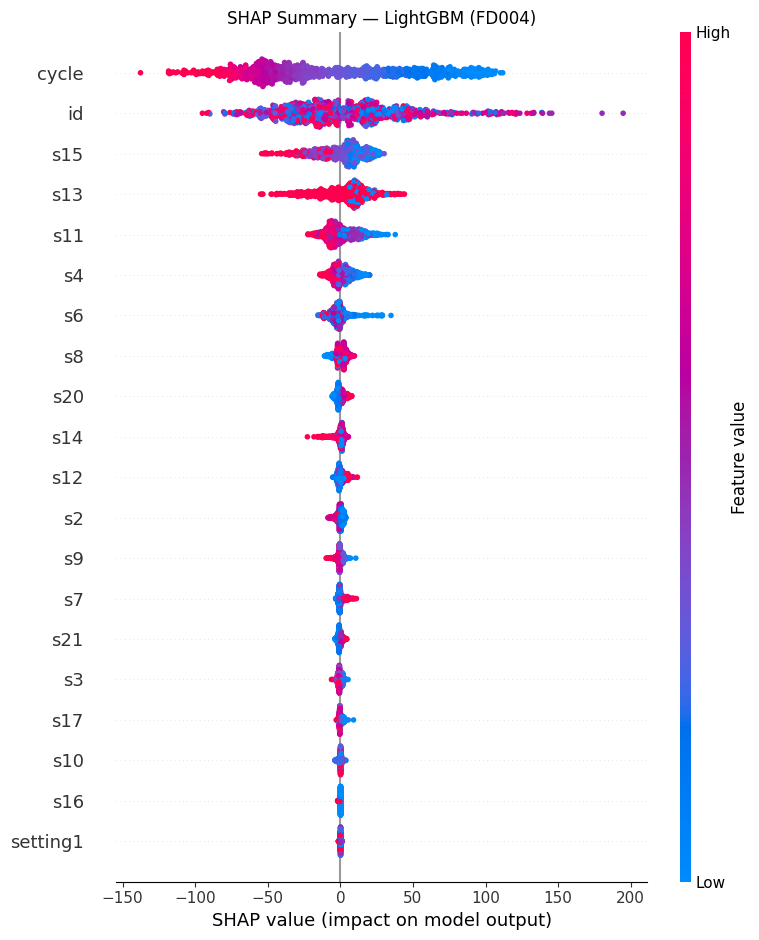

Plotting SHAP summary (CatBoost)...


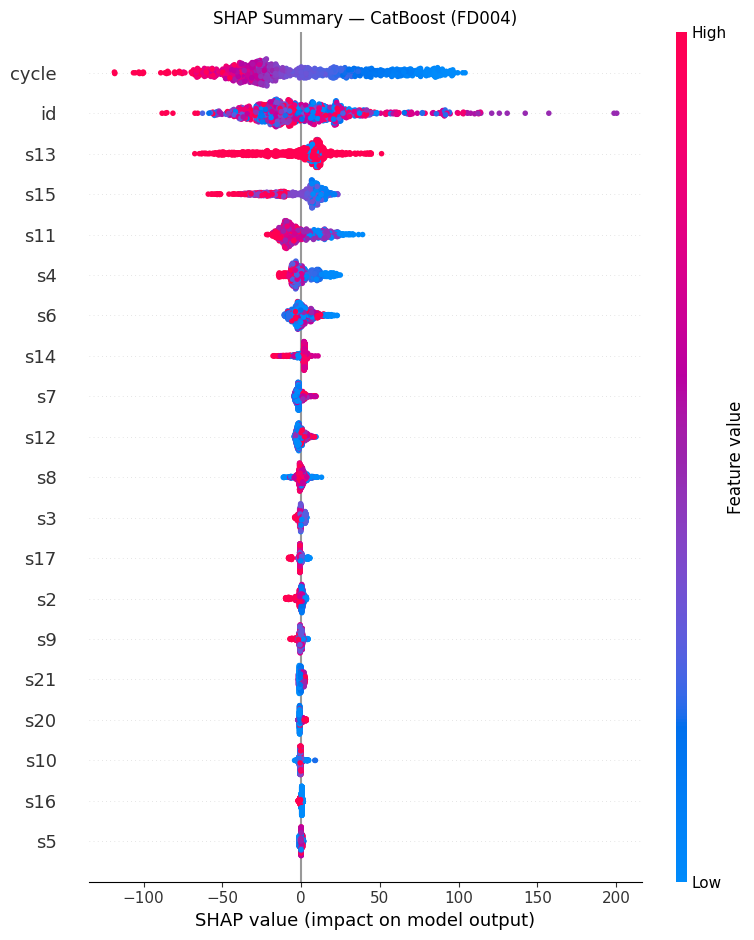

Plotting SHAP summary (Ensemble)...


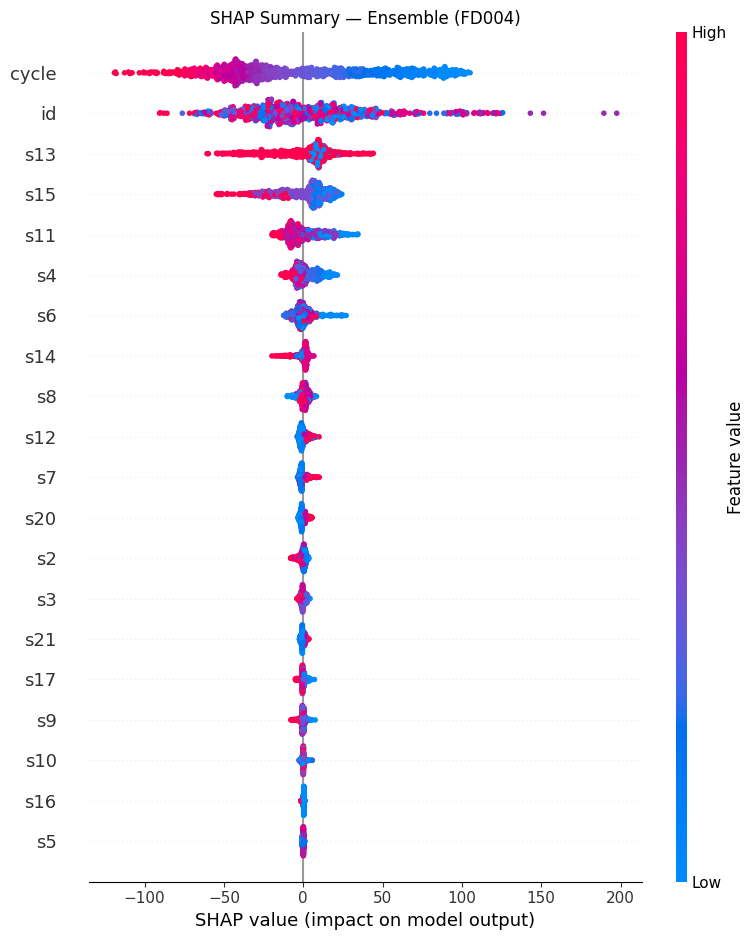

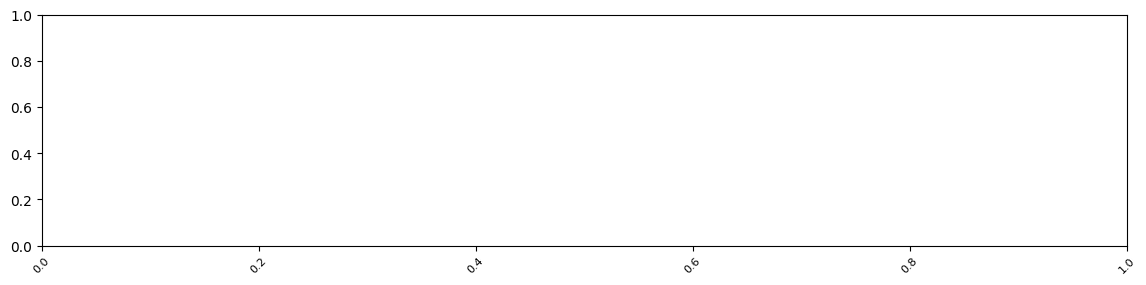

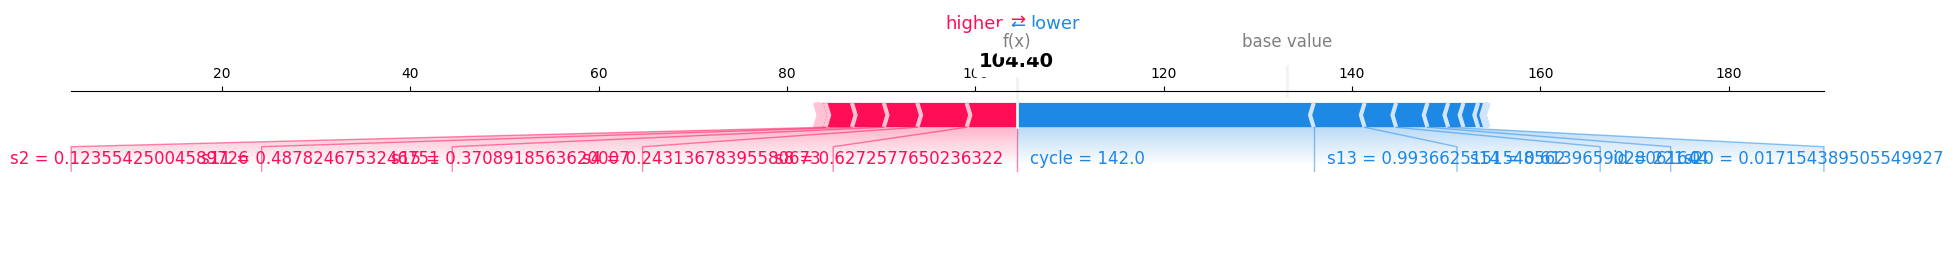

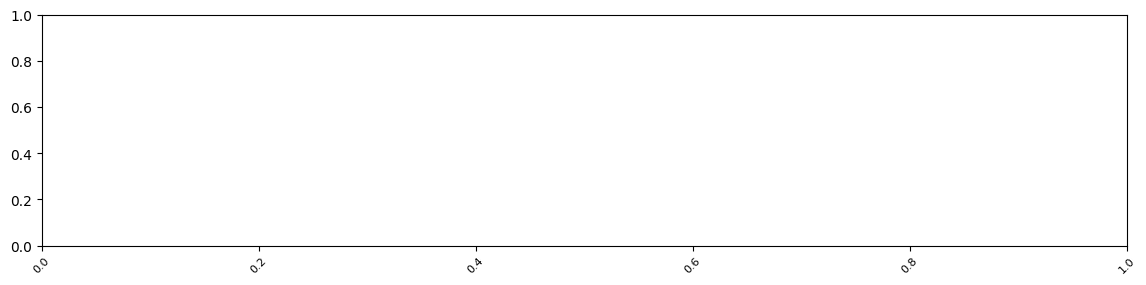

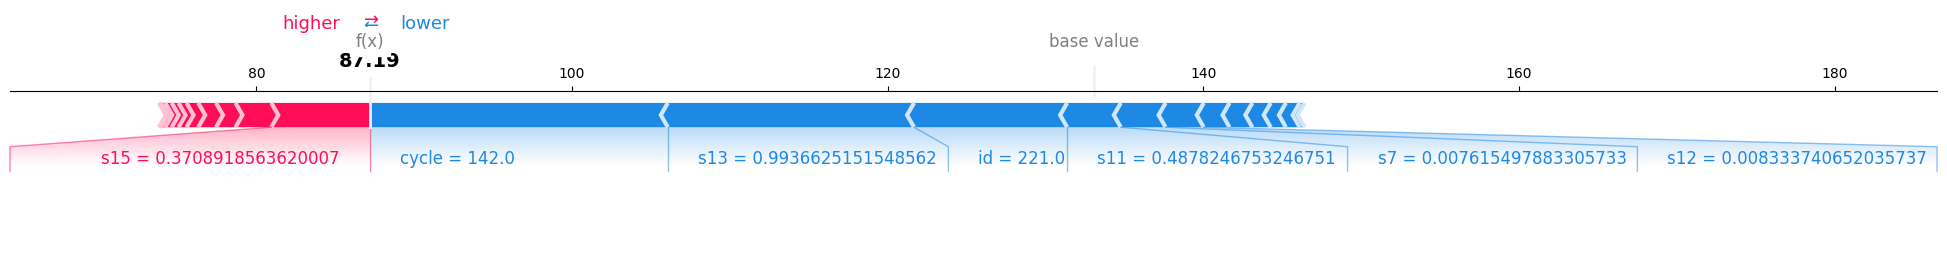

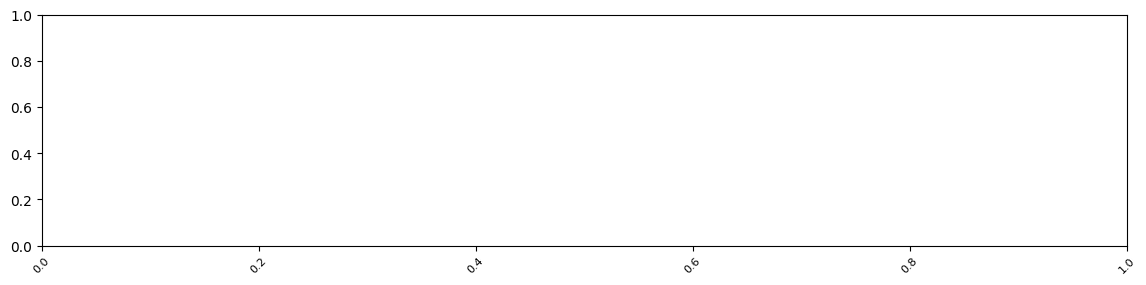

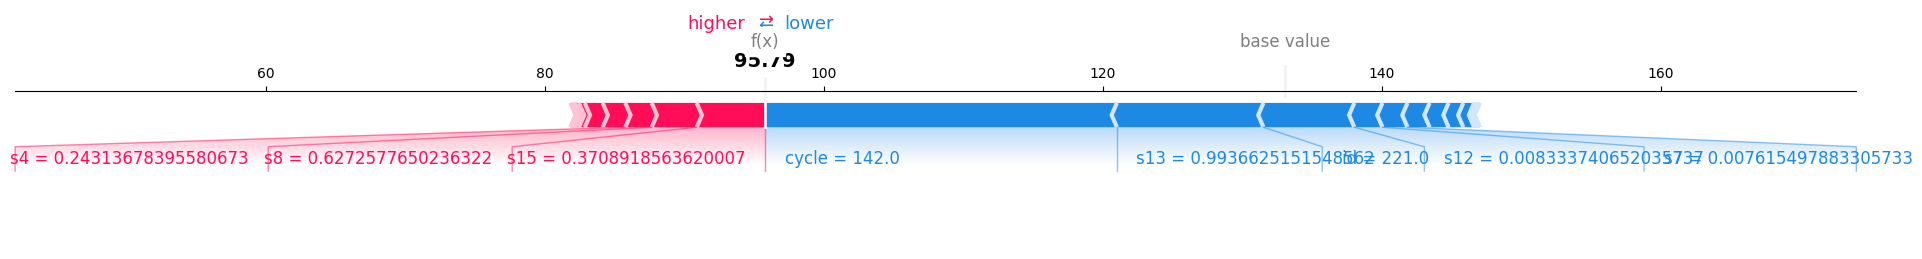

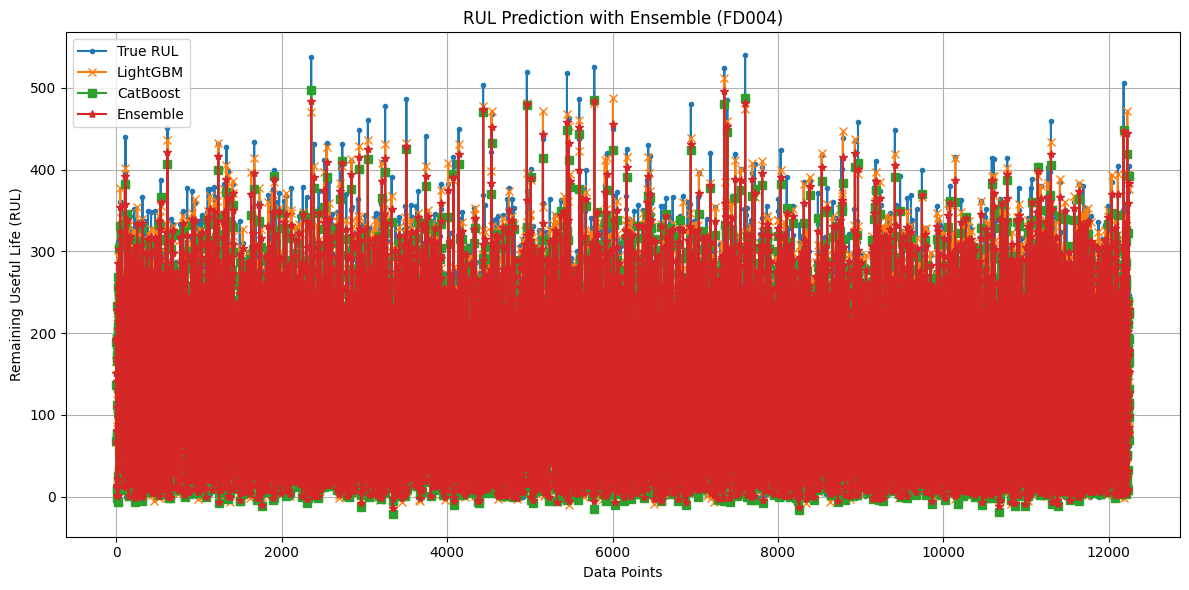



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (LightGBM) ---
Fold1: R2=0.3422, RMSE=75.2347, MAE=55.1783, PHM08_sum=5303434808.7900, PHM08_avg=431875.7988
Fold2: R2=0.1473, RMSE=83.0327, MAE=60.1237, PHM08_sum=229111997468104.5312, PHM08_avg=18863164619.4718
Fold3: R2=0.5378, RMSE=60.4301, MAE=43.8763, PHM08_sum=3277291086.5969, PHM08_avg=267032.5989
Fold4: R2=0.5332, RMSE=60.5618, MAE=44.3961, PHM08_sum=142634962976.4722, PHM08_avg=11620902.9637
Fold5: R2=0.6199, RMSE=54.6343, MAE=41.3030, PHM08_sum=3949003021.4744, PHM08_avg=321684.8339
Overall: R2=0.4334, RMSE=67.5799, MAE=48.9526, PHM08_sum=229267162159997.8438, PHM08_avg=3743198454.8319

--- GroupKFold (CatBoost) ---
Fold1: R2=0.3511, RMSE=74.7260, MAE=55.9007, PHM08_sum=8327068709.8529, PHM08_avg=678100.0578
Fold2: R2=0.3499, RMSE=72.5010, MA

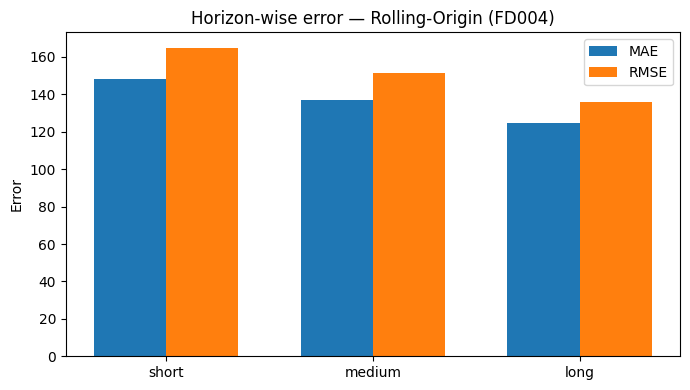

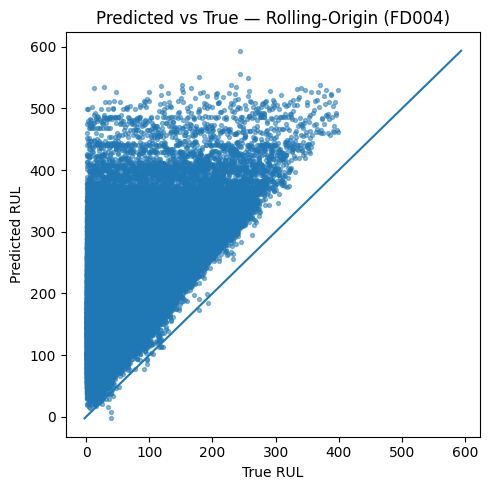


[PER-ENGINE MAE] (Top 10 worst engines)
118    241.105297
133    215.732382
49     203.144895
173    201.507604
179    200.893869
225    197.259939
171    189.647385
88     188.144300
158    183.721106
190    183.170676
dtype: float64


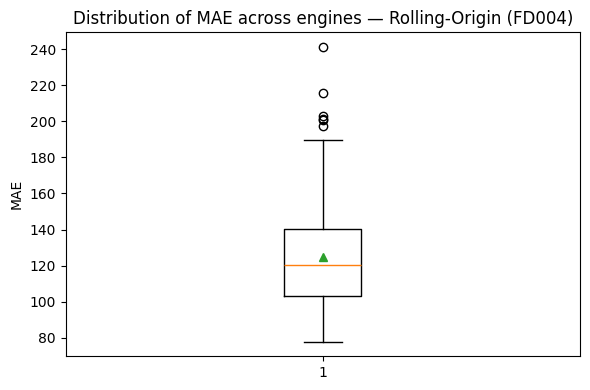

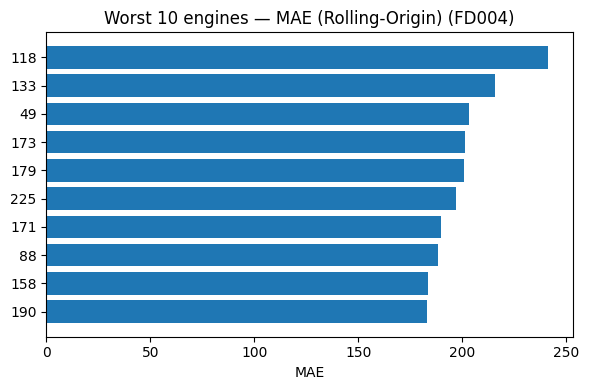


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -6.0757
    RMSE: 149.5211
     MAE: 135.2885
 sMAPE_%: 108.9295

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.4361 ± 0.1708
Without id/cycle : R²=0.5941 ± 0.0395


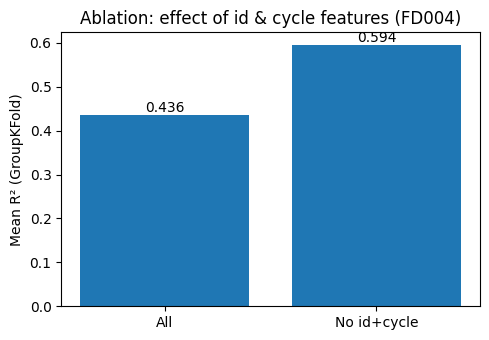


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 61249
Train (80%)   : 48999  → ratio=0.8000
Test  (20%)   : 12250  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 764.43 seconds
CPU% at start        : 3.0%   (~0.08 GHz)
CPU% at end          : 87.2%   (~2.26 GHz)
Memory at start      : 727.55 MB
Memory at end        : 742.52 MB   (Δ 14.96 MB)


In [4]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD004"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "catboostlightgbm"

# Fixed model hyperparameters (as requested)
LGB_PARAMS = dict(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=-1,      # silence LightGBM warnings
)

CB_PARAMS = dict(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,         # silence CatBoost training logs
    loss_function='RMSE'
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

# ============================================
# Output paths — single, unified directory
# ============================================
# All outputs (PNG, TXT, CSV) go into this folder:
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    """Save current matplotlib figure as PNG into OUTPUT_DIR."""
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    """Save text into OUTPUT_DIR."""
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    """Save DataFrame as CSV into OUTPUT_DIR."""
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# Model training (LightGBM + CatBoost)
# ============================================
lgb_model = lgb.LGBMRegressor(**LGB_PARAMS)
lgb_model.fit(X_train, y_train)
y_lgb = lgb_model.predict(X_val)

cb_model = CatBoostRegressor(**CB_PARAMS)
cb_model.fit(X_train, y_train)
y_cb = cb_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_lgb + 0.5 * y_cb

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_lgb = print_block_metrics("LightGBM", y_val, y_lgb)
m_cb  = print_block_metrics("CatBoost", y_val, y_cb)
m_ens = print_block_metrics("Ensemble", y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_lgb, m_cb, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer) + Ensemble SHAP
# ============================================
n_samples = min(1000, X_val.shape[0])
X_shap = X_val.sample(n=n_samples, random_state=42)

# LightGBM
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_vals_lgb = explainer_lgb.shap_values(X_shap)
print("Plotting SHAP summary (LightGBM)...")
shap.summary_plot(shap_vals_lgb, X_shap, show=False)
plt.title(f"SHAP Summary — LightGBM ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_LightGBM_{DATASET_NAME}.png")
plt.show()

# CatBoost
pool = Pool(X_shap)
cat_shap = cb_model.get_feature_importance(data=pool, type='ShapValues')
cat_shap = np.array(cat_shap)
# CatBoost returns [n_samples, n_features+1] with last column the expected value; for multiclass it's 3D
shap_vals_cat = cat_shap[:, :-1] if cat_shap.ndim == 2 else cat_shap[:, :, :-1].mean(axis=0)
print("Plotting SHAP summary (CatBoost)...")
shap.summary_plot(shap_vals_cat, X_shap, show=False)
plt.title(f"SHAP Summary — CatBoost ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_CatBoost_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP: simple average of per-feature contributions
shap_vals_ens = (shap_vals_lgb + shap_vals_cat) / 2
print("Plotting SHAP summary (Ensemble)...")
shap.summary_plot(shap_vals_ens, X_shap, show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# Single-row force plots
row = X_shap.iloc[[0]]
sv_lgb_row = explainer_lgb.shap_values(row)
if isinstance(sv_lgb_row, list):  # compatibility for multiclass API
    sv_lgb_row = sv_lgb_row[0]
sv_lgb_row = np.asarray(sv_lgb_row)[0]
expected_lgb = explainer_lgb.expected_value
if isinstance(expected_lgb, (list, np.ndarray)):
    expected_lgb = float(np.asarray(expected_lgb).mean())

pool_row = Pool(row)
cat_row_full = cb_model.get_feature_importance(data=pool_row, type="ShapValues")  # (1, n_features+1)
sv_cat_row = cat_row_full[0, :-1]
expected_cb = float(cat_row_full[0, -1])

sv_ens_row = (sv_lgb_row + sv_cat_row) / 2.0
expected_ens = (expected_lgb + expected_cb) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_lgb, sv_lgb_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_LightGBM_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_cb, sv_cat_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_CatBoost_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_ens, sv_ens_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_lgb)),      y_lgb,          label="LightGBM",  marker='x')
plt.plot(range(len(y_cb)),       y_cb,           label="CatBoost",  marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30          # window length (cycles) for purge guidance
H = 1           # prediction horizon (steps ahead)
EMBARGO = 10    # cycles to skip between train/test within a split
N_SPLITS = 5    # number of rolling-origin cuts per engine

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaler
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_lgb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", lgb.LGBMRegressor(**LGB_PARAMS))
])

pipe_cb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", CatBoostRegressor(**CB_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
overall_A_lgb = cv_eval_pipeline(X, y, groups, pipe_lgb, name="LightGBM")
overall_A_cb  = cv_eval_pipeline(X, y, groups, pipe_cb,  name="CatBoost")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))  # purge ≈ W-1
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_lgb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])

def build_pipe_cb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", CatBoostRegressor(**CB_PARAMS))
    ])

overall_B_lgb = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb, name="LightGBM"
)
overall_B_cb  = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_cb,  name="CatBoost"
)

# A/B Experiments to evidence leakage (ΔR² sensitivity)
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_lgb, name="LightGBM")
_ = cv_eval_pipeline(X, y, groups, build_pipe_lgb(), name="LightGBM (GroupKFold)")
# Rolling-origin already printed above

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb,
    embargo_val=0,  name=f"Rolling-Origin LightGBM (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb,
    embargo_val=10, name=f"Rolling-Origin LightGBM (Embargo=10, {DATASET_NAME})"
)

# Permutation (Null) Test — should collapse performance ~ baseline
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def rolling_origin_backtest_generic(df_all, features, estimator, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            est = clone(estimator)
            est.fit(X_tr, y_tr)
            p = est.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] Null test produced no folds.")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"{name}")
    return overall

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb, n_iters=1
)

# Horizon-wise error profile
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

def horizon_profile_report(y_true, y_pred, title="Horizon-wise Error"):
    dfm = pd.DataFrame({"y": y_true, "p": y_pred})
    dfm["bin"] = horizon_bins(dfm["y"])
    rows = []
    for b, g in dfm.groupby("bin"):
        rows.append(ts_metrics(g["y"].values, g["p"].values, prefix=f"{b}_"))
    print_metrics_table(rows, title=title)

hy, hp = None, None
def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb
)
if hy is not None:
    horizon_profile_report(hy, hp, title=f"Horizon-wise Error (Rolling-Origin LightGBM, {DATASET_NAME})")

print("\n================ END OF TIME-SERIES ADD-ONS ================\n")

# ===========================================
# ADDITIONAL ROBUSTNESS ANALYSES & PLOTS
# ===========================================
print("\n\n================ ADDITIONAL ROBUSTNESS ANALYSES ================\n")

# Horizon-wise error table + plots
if hy is not None:
    bins = horizon_bins(pd.Series(hy))
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": bins})
    met = (dfm
           .groupby("bin", dropna=False)
           .apply(lambda g: pd.Series({
               "MAE": mean_absolute_error(g["y"], g["p"]),
               "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
               "R2": r2_score(g["y"], g["p"])
           }))
          ).reset_index()

    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met))
    w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    lo = float(min(np.min(hy), np.min(hp)))
    hi = float(max(np.max(hy), np.max(hp)))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# Per-engine error distribution
def rolling_origin_engine_errors(df_all, features, model_builder):
    """Returns absolute errors for each engine in rolling-origin splits."""
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb
)

if per_engine:
    mae_series = pd.Series({eid: np.mean(v) for eid, v in per_engine.items()}).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))

    # Burada eski satır yerine yeni satır
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# sMAPE + overall rolling-origin metrics
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# Ablation: effect of including id & cycle
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_lgb)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_lgb)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")


LightGBM Performance:
  R^2 Score:           0.9830
  Mean Squared Error:  136.9355
  Mean Absolute Error: 8.8780
  PHM08 Score (sum):   25974.5151
  PHM08 Score (avg):   2.1204

CatBoost Performance:
  R^2 Score:           0.9403
  Mean Squared Error:  479.8289
  Mean Absolute Error: 16.9850
  PHM08 Score (sum):   174405.5979
  PHM08 Score (avg):   14.2372

Ensemble Performance:
  R^2 Score:           0.9696
  Mean Squared Error:  244.1383
  Mean Absolute Error: 12.0480
  PHM08 Score (sum):   51682.9743
  PHM08 Score (avg):   4.2190
Plotting SHAP summary (LightGBM)...


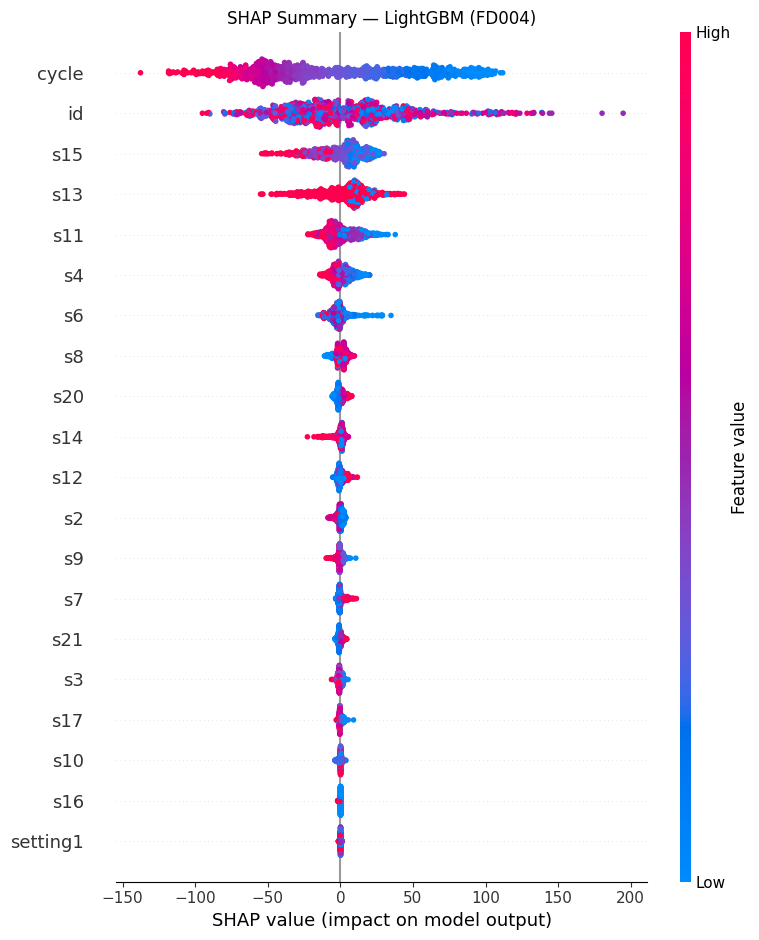

Plotting SHAP summary (CatBoost)...


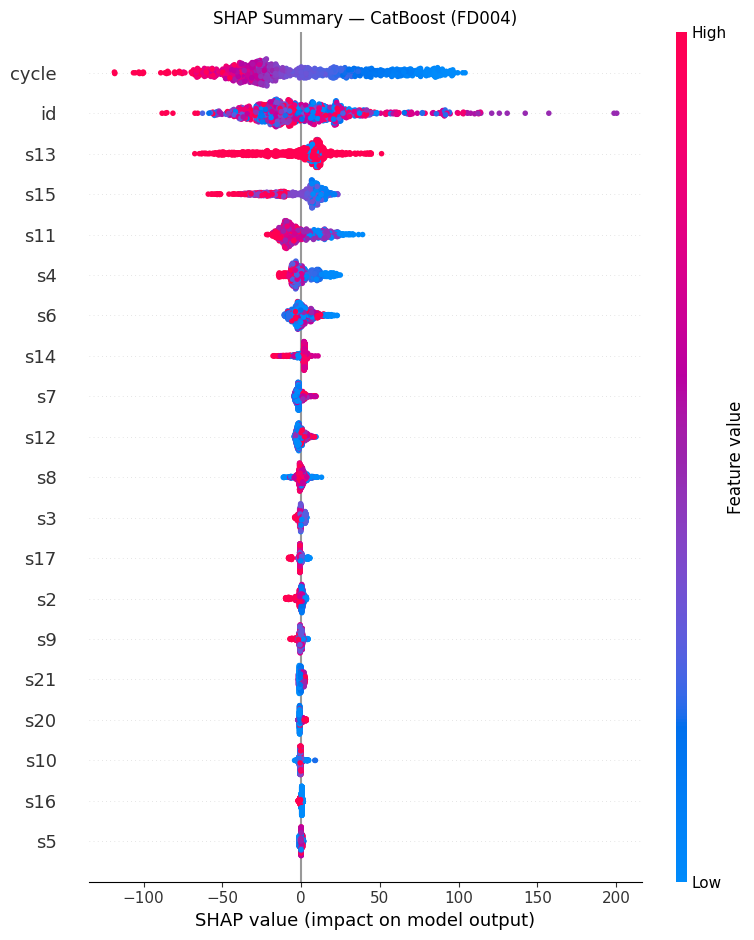

Plotting SHAP summary (Ensemble)...


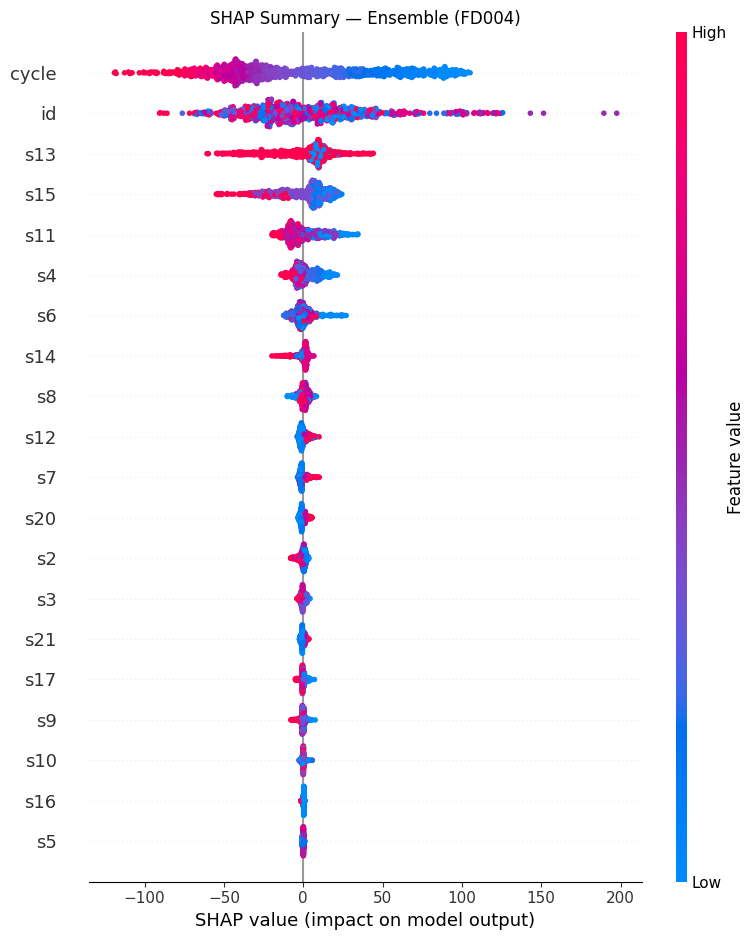

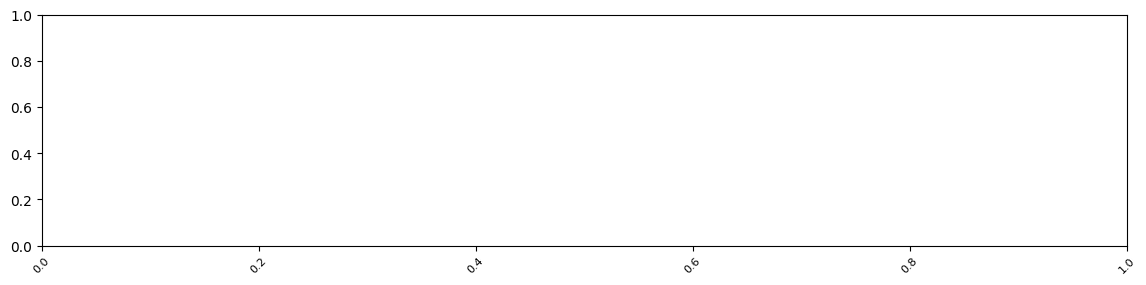

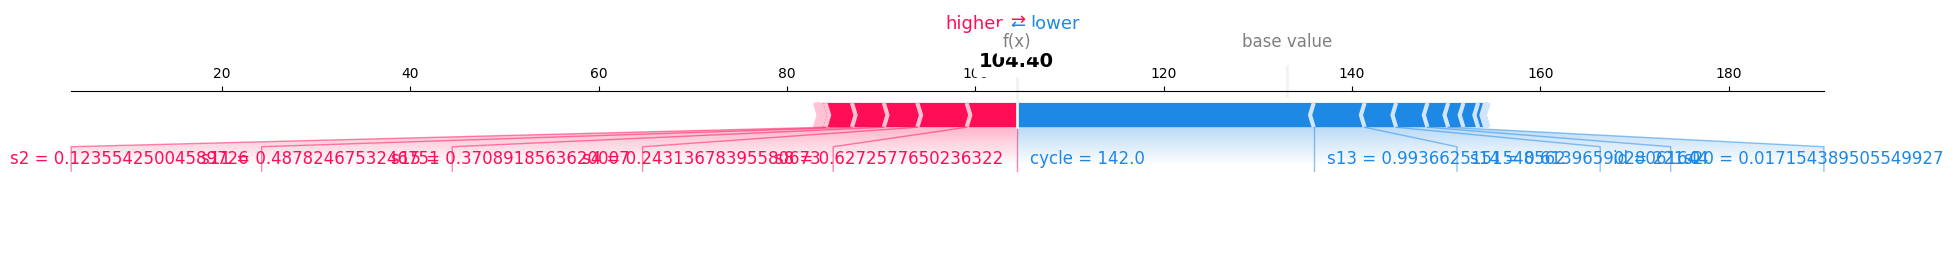

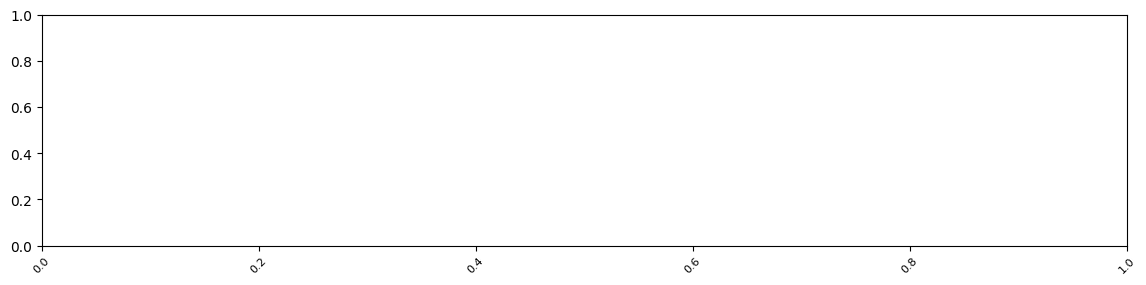

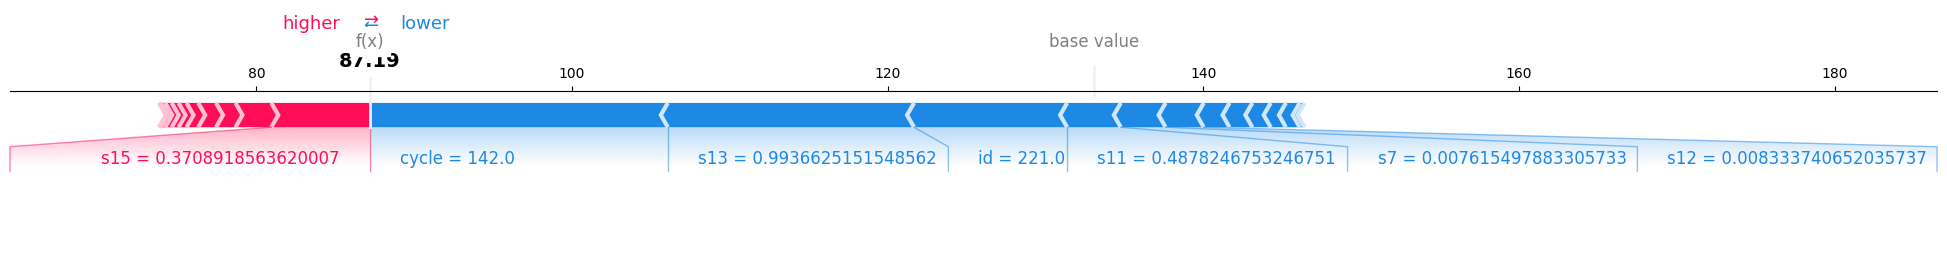

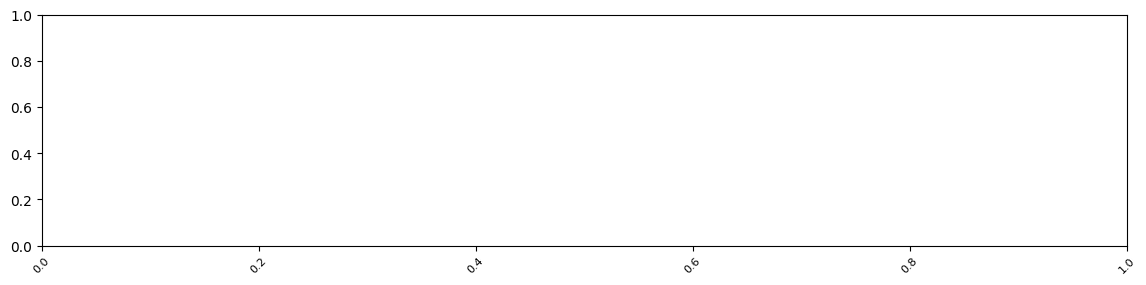

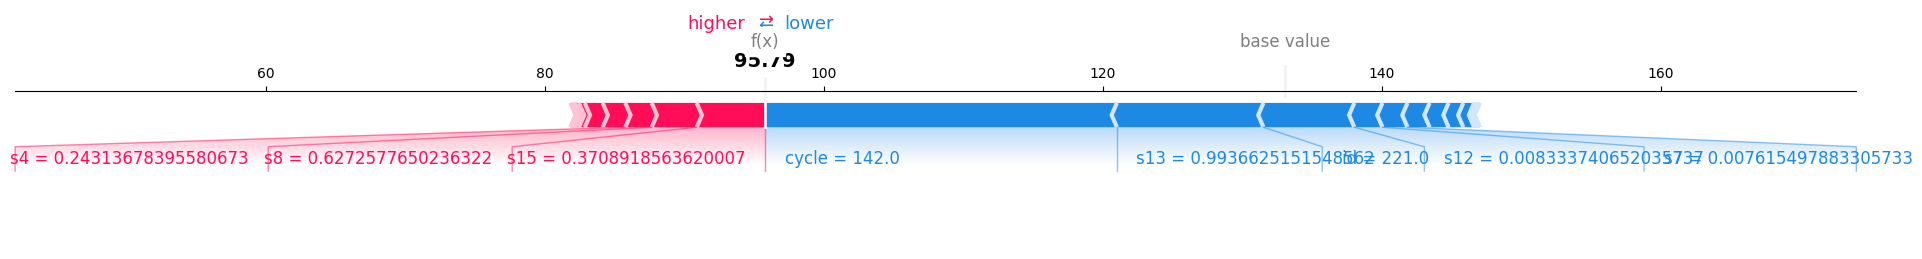

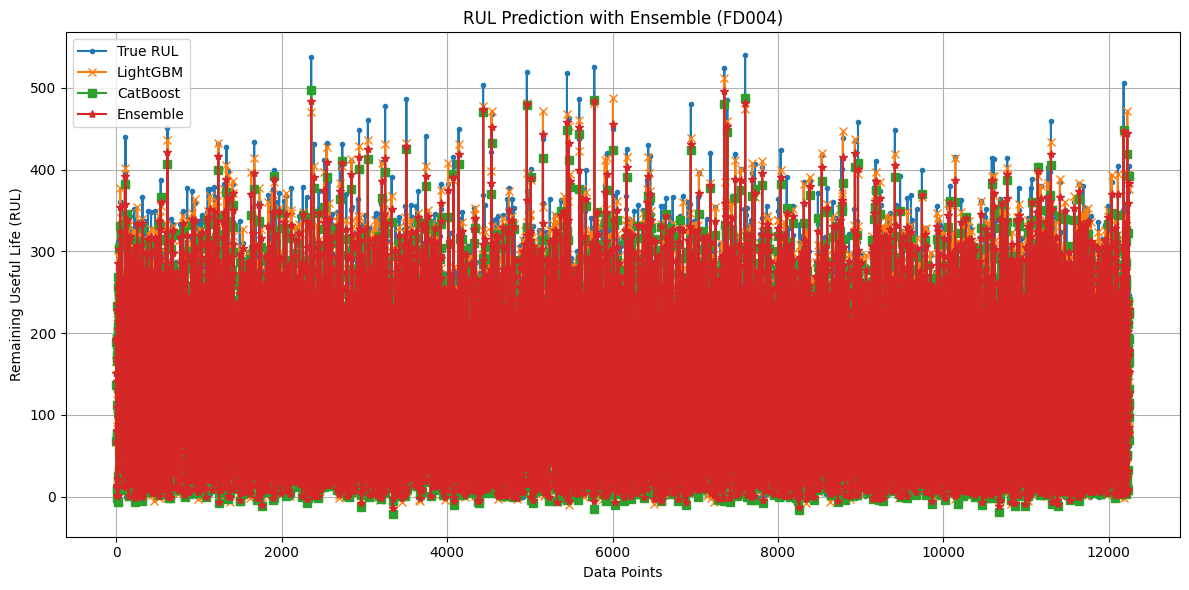



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (LightGBM) ---
Fold1: R2=0.3422, RMSE=75.2347, MAE=55.1783, PHM08_sum=5303434808.7900, PHM08_avg=431875.7988
Fold2: R2=0.1473, RMSE=83.0327, MAE=60.1237, PHM08_sum=229111997468104.5312, PHM08_avg=18863164619.4718
Fold3: R2=0.5378, RMSE=60.4301, MAE=43.8763, PHM08_sum=3277291086.5969, PHM08_avg=267032.5989
Fold4: R2=0.5332, RMSE=60.5618, MAE=44.3961, PHM08_sum=142634962976.4722, PHM08_avg=11620902.9637
Fold5: R2=0.6199, RMSE=54.6343, MAE=41.3030, PHM08_sum=3949003021.4744, PHM08_avg=321684.8339
Overall: R2=0.4334, RMSE=67.5799, MAE=48.9526, PHM08_sum=229267162159997.8438, PHM08_avg=3743198454.8319

--- GroupKFold (CatBoost) ---
Fold1: R2=0.3511, RMSE=74.7260, MAE=55.9007, PHM08_sum=8327068709.8529, PHM08_avg=678100.0578
Fold2: R2=0.3499, RMSE=72.5010, MA

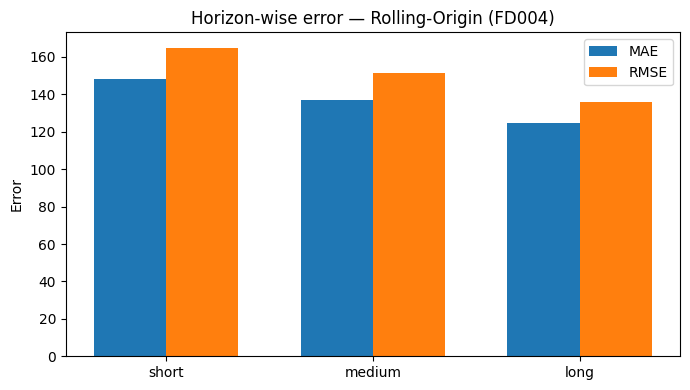

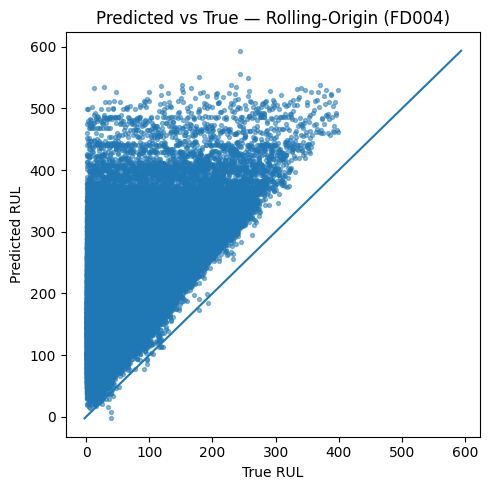


[PER-ENGINE MAE] (Top 10 worst engines)
118    241.105297
133    215.732382
49     203.144895
173    201.507604
179    200.893869
225    197.259939
171    189.647385
88     188.144300
158    183.721106
190    183.170676
dtype: float64


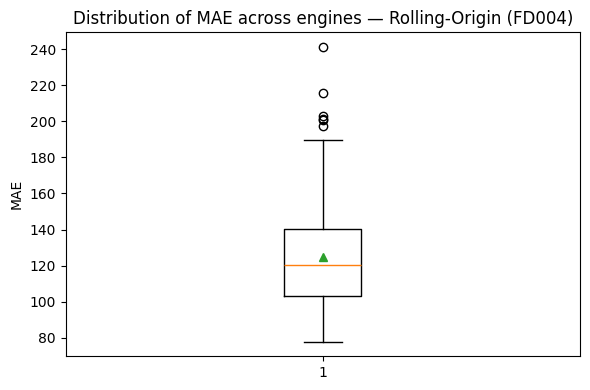

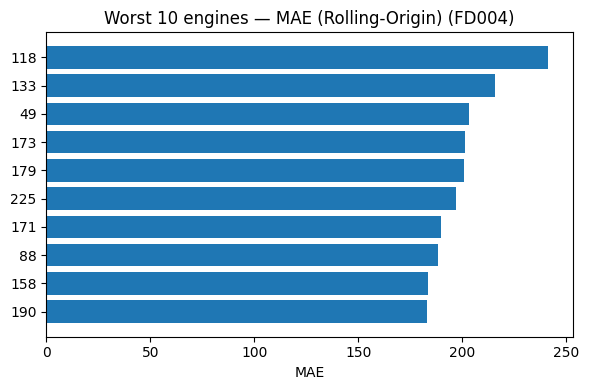


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -6.0757
    RMSE: 149.5211
     MAE: 135.2885
 sMAPE_%: 108.9295

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.4361 ± 0.1708
Without id/cycle : R²=0.5941 ± 0.0395


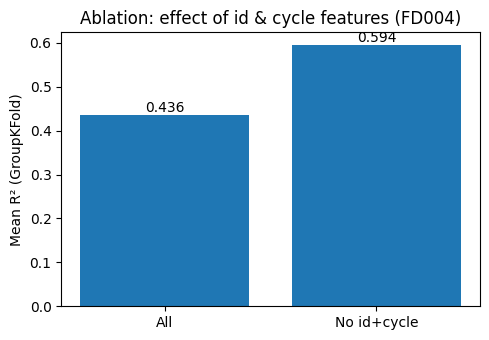


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 61249
Train (80%)   : 48999  → ratio=0.8000
Test  (20%)   : 12250  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 764.43 seconds
CPU% at start        : 3.0%   (~0.08 GHz)
CPU% at end          : 87.2%   (~2.26 GHz)
Memory at start      : 727.55 MB
Memory at end        : 742.52 MB   (Δ 14.96 MB)


In [4]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD004"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "catboostlightgbm"

# Fixed model hyperparameters (as requested)
LGB_PARAMS = dict(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=-1,      # silence LightGBM warnings
)

CB_PARAMS = dict(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,         # silence CatBoost training logs
    loss_function='RMSE'
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

# ============================================
# Output paths — single, unified directory
# ============================================
# All outputs (PNG, TXT, CSV) go into this folder:
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    """Save current matplotlib figure as PNG into OUTPUT_DIR."""
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    """Save text into OUTPUT_DIR."""
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    """Save DataFrame as CSV into OUTPUT_DIR."""
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# Model training (LightGBM + CatBoost)
# ============================================
lgb_model = lgb.LGBMRegressor(**LGB_PARAMS)
lgb_model.fit(X_train, y_train)
y_lgb = lgb_model.predict(X_val)

cb_model = CatBoostRegressor(**CB_PARAMS)
cb_model.fit(X_train, y_train)
y_cb = cb_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_lgb + 0.5 * y_cb

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_lgb = print_block_metrics("LightGBM", y_val, y_lgb)
m_cb  = print_block_metrics("CatBoost", y_val, y_cb)
m_ens = print_block_metrics("Ensemble", y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_lgb, m_cb, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer) + Ensemble SHAP
# ============================================
n_samples = min(1000, X_val.shape[0])
X_shap = X_val.sample(n=n_samples, random_state=42)

# LightGBM
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_vals_lgb = explainer_lgb.shap_values(X_shap)
print("Plotting SHAP summary (LightGBM)...")
shap.summary_plot(shap_vals_lgb, X_shap, show=False)
plt.title(f"SHAP Summary — LightGBM ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_LightGBM_{DATASET_NAME}.png")
plt.show()

# CatBoost
pool = Pool(X_shap)
cat_shap = cb_model.get_feature_importance(data=pool, type='ShapValues')
cat_shap = np.array(cat_shap)
# CatBoost returns [n_samples, n_features+1] with last column the expected value; for multiclass it's 3D
shap_vals_cat = cat_shap[:, :-1] if cat_shap.ndim == 2 else cat_shap[:, :, :-1].mean(axis=0)
print("Plotting SHAP summary (CatBoost)...")
shap.summary_plot(shap_vals_cat, X_shap, show=False)
plt.title(f"SHAP Summary — CatBoost ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_CatBoost_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP: simple average of per-feature contributions
shap_vals_ens = (shap_vals_lgb + shap_vals_cat) / 2
print("Plotting SHAP summary (Ensemble)...")
shap.summary_plot(shap_vals_ens, X_shap, show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# Single-row force plots
row = X_shap.iloc[[0]]
sv_lgb_row = explainer_lgb.shap_values(row)
if isinstance(sv_lgb_row, list):  # compatibility for multiclass API
    sv_lgb_row = sv_lgb_row[0]
sv_lgb_row = np.asarray(sv_lgb_row)[0]
expected_lgb = explainer_lgb.expected_value
if isinstance(expected_lgb, (list, np.ndarray)):
    expected_lgb = float(np.asarray(expected_lgb).mean())

pool_row = Pool(row)
cat_row_full = cb_model.get_feature_importance(data=pool_row, type="ShapValues")  # (1, n_features+1)
sv_cat_row = cat_row_full[0, :-1]
expected_cb = float(cat_row_full[0, -1])

sv_ens_row = (sv_lgb_row + sv_cat_row) / 2.0
expected_ens = (expected_lgb + expected_cb) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_lgb, sv_lgb_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_LightGBM_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_cb, sv_cat_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_CatBoost_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(expected_ens, sv_ens_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_lgb)),      y_lgb,          label="LightGBM",  marker='x')
plt.plot(range(len(y_cb)),       y_cb,           label="CatBoost",  marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30          # window length (cycles) for purge guidance
H = 1           # prediction horizon (steps ahead)
EMBARGO = 10    # cycles to skip between train/test within a split
N_SPLITS = 5    # number of rolling-origin cuts per engine

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaler
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_lgb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", lgb.LGBMRegressor(**LGB_PARAMS))
])

pipe_cb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", CatBoostRegressor(**CB_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
overall_A_lgb = cv_eval_pipeline(X, y, groups, pipe_lgb, name="LightGBM")
overall_A_cb  = cv_eval_pipeline(X, y, groups, pipe_cb,  name="CatBoost")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))  # purge ≈ W-1
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_lgb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])

def build_pipe_cb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", CatBoostRegressor(**CB_PARAMS))
    ])

overall_B_lgb = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb, name="LightGBM"
)
overall_B_cb  = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_cb,  name="CatBoost"
)

# A/B Experiments to evidence leakage (ΔR² sensitivity)
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", lgb.LGBMRegressor(**LGB_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_lgb, name="LightGBM")
_ = cv_eval_pipeline(X, y, groups, build_pipe_lgb(), name="LightGBM (GroupKFold)")
# Rolling-origin already printed above

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb,
    embargo_val=0,  name=f"Rolling-Origin LightGBM (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb,
    embargo_val=10, name=f"Rolling-Origin LightGBM (Embargo=10, {DATASET_NAME})"
)

# Permutation (Null) Test — should collapse performance ~ baseline
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def rolling_origin_backtest_generic(df_all, features, estimator, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            est = clone(estimator)
            est.fit(X_tr, y_tr)
            p = est.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] Null test produced no folds.")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"{name}")
    return overall

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb, n_iters=1
)

# Horizon-wise error profile
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

def horizon_profile_report(y_true, y_pred, title="Horizon-wise Error"):
    dfm = pd.DataFrame({"y": y_true, "p": y_pred})
    dfm["bin"] = horizon_bins(dfm["y"])
    rows = []
    for b, g in dfm.groupby("bin"):
        rows.append(ts_metrics(g["y"].values, g["p"].values, prefix=f"{b}_"))
    print_metrics_table(rows, title=title)

hy, hp = None, None
def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb
)
if hy is not None:
    horizon_profile_report(hy, hp, title=f"Horizon-wise Error (Rolling-Origin LightGBM, {DATASET_NAME})")

print("\n================ END OF TIME-SERIES ADD-ONS ================\n")

# ===========================================
# ADDITIONAL ROBUSTNESS ANALYSES & PLOTS
# ===========================================
print("\n\n================ ADDITIONAL ROBUSTNESS ANALYSES ================\n")

# Horizon-wise error table + plots
if hy is not None:
    bins = horizon_bins(pd.Series(hy))
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": bins})
    met = (dfm
           .groupby("bin", dropna=False)
           .apply(lambda g: pd.Series({
               "MAE": mean_absolute_error(g["y"], g["p"]),
               "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
               "R2": r2_score(g["y"], g["p"])
           }))
          ).reset_index()

    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met))
    w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    lo = float(min(np.min(hy), np.min(hp)))
    hi = float(max(np.max(hy), np.max(hp)))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# Per-engine error distribution
def rolling_origin_engine_errors(df_all, features, model_builder):
    """Returns absolute errors for each engine in rolling-origin splits."""
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_lgb
)

if per_engine:
    mae_series = pd.Series({eid: np.mean(v) for eid, v in per_engine.items()}).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))

    # Burada eski satır yerine yeni satır
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# sMAPE + overall rolling-origin metrics
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# Ablation: effect of including id & cycle
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_lgb)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_lgb)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")